# Data Exploration and PreProcessing Notebook
Welcome to the Data Exploration and Preprocessing Notebook for our project, delivered in Part 1 of our data science endeavor. This Jupyter notebook serves as a comprehensive guide detailing the exploration and preprocessing steps applied to the raw data. Our objective is to provide insight into the initial stages of our data analysis pipeline, including data cleansing, feature engineering, and any transformations performed on the dataset.

In this notebook, we will embark on a journey to uncover the intricacies of our dataset, understand its structure, identify potential issues, and prepare it for further analysis. By meticulously exploring and preprocessing the data, we aim to lay a solid foundation for subsequent stages of our project, enabling us to derive meaningful insights and build robust machine learning models.

# Each feature provides valuable insights into the health profile of individuals. Here's a quick overview of the key features:

- **HeartDisease**: Indicates whether respondents have ever reported having coronary heart disease (CHD) or my-ocardial infarction (MI).
- **BMI (Body Mass Index)**: A measure of body fat based on height and weight.
- **Smoking**: Indicates whether respondents have smoked at least 100 cigarettes in their lifetime.
- **AlcoholDrinking**: Identifies heavy drinkers based on weekly alcohol consumption thresholds.
- **Stroke**: Indicates whether respondents have ever been told they had a stroke.
- **PhysicalHealth**: Measures the number of days in the past 30 days during which respondents’ physical health was not good.
- **MentalHealth**: Measures the number of days in the past 30 days during which respondents’ mental health was not good.
- **DiffWalking**: Indicates whether respondents have serious difficulty walking or climbing stairs.
- **Sex**: Identifies respondents gender.
- **AgeCategory**: Categorizes respondents into fourteen age groups.
- **Race**: Identifies respondents race/ethnicity.
- **Diabetic**: Indicates whether respondents have ever been told they had diabetes.
- **PhysicalActivity**: Identifies adults who reported engaging in physical activity or exercise during the past 30 days.
- **GenHealth**: Indicates respondents’ general perception of their health.
- **SleepTime**: Measures the average number of hours of sleep respondents get in a 24-hour period.
- **Asthma**: Indicates whether respondents have ever been told they had asthma.
- **KidneyDisease**: Indicates whether respondents have ever been told they had kidney disease (excluding kidney stones, bladder infection, or incontinence).
- **SkinCancer**: Indicates whether respondents have ever been told they had skin cancer.

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from scipy.stats import ttest_ind, probplot, shapiro
import statsmodels.stats.api as sms

In [96]:
class DataLoader:
    """
    Generic Class responsible for loading the dataset

    Attributes:
        filename (str): The filename of the dataset to load.
        target (str): The target of the dataset to load.

    Attributes (after loading the data):
        data (DataFrame): The main dataset containing both features and target variable.
        labels (DataFrame): The target variable.
        numerical_features (List): List of numerical features in the dataset.
        categorical_features (List): List of categorical features in the dataset.


    Methods:
        _load_data(): Loads the dataset,and assigns the data and labels to the appropriate attributes.
    """

    def __init__(self, filename, target):
        """
        Initializes the DataLoader with the filename of the dataset.

        Args:
            filename (str): The filename of the dataset to load.
            target (str): The target of the dataset to load.
        """
        self.filename = filename

        self.data = None
        self.target = target
        self.labels = None
        self.numerical_features = []
        self.categorical_features = []

        # Load data
        self._load_data(target)

    def _load_data(self, target):
        """
        Loads the dataset from the specified filename,
        and assigns the data and labels to the appropriate attributes.

        Args:
            target (str): The target of the dataset to load.
        """
        try:
            # Load the dataset
            self.data = pd.read_csv(self.filename)

            # Validate if the target column exists in the dataset
            if target not in self.data.columns:
                raise ValueError(f"Target column '{target}' not found in the dataset.")

            self.labels = self.data[target]

            print("Data loaded successfully.")

        except FileNotFoundError:
            print("File not found. Please check the file path.")

In [97]:
class DataManipulator(DataLoader):
    """
    A class for manipulating data loaded from a file.

    Args:
        filename (str): The path to the data file.
        target (str): The target variable in the data.

    Attributes:
        data (DataFrame): The loaded data.

    Methods:
        _describe_variables: Prints information about the data, including data info, unique values, and statistical distribution.

    Raises:
        FileNotFoundError: If the specified file is not found.

    """

    def __init__(self, filename, target):
        """
        Initialize the class with a filename and target variable.

        Args:
            filename (str): The path to the file.
            target (str): The name of the target variable.

        Raises:
            FileNotFoundError: If the file is not found.

        """
        try:
            super().__init__(filename, target)
            print("\nData Description:")
            self._describe_variables()
        except FileNotFoundError:
            print("File not found. Please check the file path.")

    def _describe_variables(self):
        """
        Prints information about the data, including data info, unique values, and statistical distribution.
        """
        print("\nInformation of Data:")
        print(self.data.info())

        print("\nUnique values of features:")
        print(self.data.nunique())

        print("\nStatistical distribution of each variable:")
        print(self.data.describe())

In [98]:
class DataPreProcessing:
    """
    Class for performing data preprocessing tasks, mostly encoding.

    Args:
        data_loader (DataLoader): The DataLoader object containing the dataset.

    Attributes:
        data_loader (DataLoader): The DataLoader object containing the dataset.

    Methods:
        _sanity_check(): Performs a sanity check on the DataLoader object.
        _determine_range(): Displays the range of values for each variable without considering the class label.
        _age_encode(): Encodes the AgeCategory variable into numerical values.
        _encode_numerical_values(column, mapping): Encodes a variable into numerical values using the provided mapping.
        _encode_data(): Encodes categorical features into numerical values and fills numerical and categorical features arrays.
    """

    def __init__(self, data_loader):
        """
        Initializes an instance of the class.

        Args:
            data_loader: The data loader object used to load the data.
        """
        self.data_loader = data_loader

        self._sanity_check()

        self._encode_data()

        self._determine_range()

    def _sanity_check(self):
        """
        Performs a sanity check on the DataLoader object.

        Raises:
            ValueError: If the DataLoader object is not provided or is not a pandas DataFrame.
        """
        try:
            if not self.data_loader:
                raise ValueError("DataLoader object is not provided.")
            if not isinstance(self.data_loader.data, pd.DataFrame):
                raise ValueError("Invalid DataLoader object. It should contain a pandas DataFrame.")
        except Exception as error:
            print(f"Error occurred: {error}")
            return False

    def _determine_range(self):
        """
        Displays the range of values for each variable without considering the class label.
        """
        print("\nRange of values for each variable:")
        print(self.data_loader.data.drop(columns=["HeartDisease"]).max() - self.data_loader.data.drop(columns=["HeartDisease"]).min())

    def _age_encode(self):
        """
        Encodes AgeCategory into numerical values.
        """
        age_map = {
            "18-24": 1, "25-29": 2, "30-34": 3, "35-39": 4,
            "40-44": 5, "45-49": 6, "50-54": 7, "55-59": 8,
            "60-64": 9, "65-69": 10, "70-74": 11, "75-79": 12,
            "80 or older": 13
        }
        self.data_loader.data["AgeCategory"] = self.data_loader.data["AgeCategory"].map(age_map)

    def _encode_numerical_values(self, column, mapping):
        """
        Encodes a variable into numerical values using the provided mapping.

        Args:
            column (str): The name of the column to be encoded.
            mapping (dict): The mapping of categorical values to numerical values.
        """
        self.data_loader.data[column] = self.data_loader.data[column].map(mapping)

    def _encode_data(self):
        """
        Encodes categorical features into numerical values and fills numerical and categorical features arrays.
        """
        # Map categorical features to numerical values
        categorical_mappings = {
            "HeartDisease": {"No": 0, "Yes": 1},
            "Smoking": {"No": 0, "Yes": 1},
            "AlcoholDrinking": {"No": 0, "Yes": 1},
            "Stroke": {"No": 0, "Yes": 1},
            "DiffWalking": {"No": 0, "Yes": 1},
            "Sex": {"Female": 0, "Male": 1},
            "Diabetic": {"No": 0, "No, borderline diabetes": 0, "Yes (during pregnancy)": 1, "Yes": 1},
            "PhysicalActivity": {"No": 0, "Yes": 1},
            "Asthma": {"No": 0, "Yes": 1},
            "KidneyDisease": {"No": 0, "Yes": 1},
            "SkinCancer": {"No": 0, "Yes": 1}
        }
        for column, mapping in categorical_mappings.items():
            self._encode_numerical_values(column, mapping)

        # Encode AgeCategory, Race, and GenHealth
        self._age_encode()
        self._encode_numerical_values("Race", {"White": 1, "Black": 2, "Hispanic": 3, "Asian": 4, "American Indian/Alaskan Native": 5, "Other": 6})
        self._encode_numerical_values("GenHealth", {"Excellent": 5, "Very good": 4, "Good": 3, "Fair": 2, "Poor": 1})

        # Fill the numerical and categorical features arrays
        self.data_loader.categorical_features.append("HeartDisease")
        self.data_loader.categorical_features.append("Smoking")
        self.data_loader.categorical_features.append("AlcoholDrinking")
        self.data_loader.categorical_features.append("Stroke")
        self.data_loader.categorical_features.append("DiffWalking")
        self.data_loader.categorical_features.append("Sex")
        self.data_loader.categorical_features.append("Race")
        self.data_loader.categorical_features.append("Diabetic")
        self.data_loader.categorical_features.append("PhysicalActivity")
        self.data_loader.categorical_features.append("GenHealth")
        self.data_loader.categorical_features.append("Asthma")
        self.data_loader.categorical_features.append("KidneyDisease")
        self.data_loader.categorical_features.append("SkinCancer")

        self.data_loader.numerical_features.append("BMI")
        self.data_loader.numerical_features.append("PhysicalHealth")
        self.data_loader.numerical_features.append("MentalHealth")
        self.data_loader.numerical_features.append("AgeCategory")
        self.data_loader.numerical_features.append("SleepTime")

        print("\nProcessed Dataset:")
        print(self.data_loader.data.info())

In [99]:
class DataCleaning:
    """
    A class for performing data cleaning operations on a dataset.

    Args:
        data_loader (DataLoader): An instance of the DataLoader class that provides access to the dataset.

    Attributes:
        data_loader (DataLoader): An instance of the DataLoader class that provides access to the dataset.

    Methods:
        handle_missing_values: Removes rows with missing values from the dataset.
        remove_duplicates: Removes duplicate rows from the dataset.
        detect_and_remove_outliers: Detects and removes outliers from the dataset.
    """

    def __init__(self, data_loader):
        """
        Initializes an instance of the class.

        Args:
            data_loader: The data loader object used to load the dataset.

        Returns:
            None
        """
        self.data_loader = data_loader
        print("\nOriginal Dataset before cleaning:")
        print(self.data_loader.data.info())

    def handle_missing_values(self):
        """
        This method checks for missing values in the dataset and removes any rows that contain missing values.
        It prints the number of missing values for each column before and after removing the rows.
        If there are no missing values, no rows are removed.
        """
        print("Missing values:\n", self.data_loader.data.isnull().sum())

        if self.data_loader.data.isnull().sum().sum() > 0:
            self.data_loader.data = self.data_loader.data.dropna()

    def remove_duplicates(self):
            """
            This method checks for duplicate rows in the dataset and removes them if any are found.
            It prints the number of duplicate rows before and after the removal process.
            """
            print("Duplicate Rows:", self.data_loader.data.duplicated().sum())

            if self.data_loader.data.duplicated().sum() > 0:
                self.data_loader.data = self.data_loader.data.drop_duplicates(keep='first')

    def detect_and_remove_outliers(self):
        """
        This method iterates over each feature in the dataset and detects outliers using the interquartile range (IQR) method.
        Outliers are defined as values that fall below the lower bound (Q1 - 1.5 * IQR) or above the upper bound (Q3 + 1.5 * IQR).
        Outliers are then removed from the dataset.

        If a feature has only two unique values, it is skipped as it is not suitable for outlier detection.
        After removing outliers, if a feature has only one unique value, it is considered redundant and is deleted from the dataset.
        """
        print("\nDetecting outliers (only numerical values):")
        features_to_delete = []
        for feature in self.data_loader.data.columns:
            # Skip features with only two unique values
            if len(self.data_loader.data[feature].unique()) == 2:
                print(f"Skipping '{feature}' as it has only two unique values.")
                continue

            q1 = self.data_loader.data[feature].quantile(0.25)
            q3 = self.data_loader.data[feature].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers_indices = self.data_loader.data[
                (self.data_loader.data[feature] < lower_bound) | (self.data_loader.data[feature] > upper_bound)].index

            print(f"Outliers in '{feature}'." if not outliers_indices.empty else f"No outliers in '{feature}'.")

            self.data_loader.data.drop(outliers_indices, inplace=True)

            # Verify if the feature after removing outliers has only one unique value
            if len(self.data_loader.data[feature].unique()) == 1:
                print(f"Feature '{feature}' has only one unique value after removing outliers. Deleting it.")
                features_to_delete.append(feature)

        # Remove features with only one unique value
        self.data_loader.data.drop(columns=features_to_delete, inplace=True)

In [100]:
class DataVisualization:
    """
    A class for visualizing data using various plot types.
    
    Args:
        data_loader (DataLoader): A DataLoader object that provides access to the data.
        valid_plot_types (list): A list of valid plot types that can be used for visualization.
    
    Attributes:
        data_loader (DataLoader): A DataLoader object that provides access to the data.
        valid_plot_types (list): A list of valid plot types that can be used for visualization.
        labels (list): A list of unique labels in the dataset.
    
    Methods:
        plot_all_features(): Plots histograms for all features in the dataset.
        plots(plot_types): Plots the specified types of plots for each feature in the dataset.
    """
    def __init__(self, data_loader, valid_plot_types):
        """
        Initializes the DataVisualization class with a DataLoader object.

        Parameters:
        - data_loader (DataLoader): The DataLoader object used to load the data.
        - valid_plot_types (list): A list of valid plot types that can be used for visualization.

        Attributes:
        - data_loader (DataLoader): The DataLoader object used to load the data.
        - valid_plot_types (list): A list of valid plot types that can be used for visualization.
        - labels (list): A list of unique labels in the loaded data.

        """
        self.data_loader = data_loader
        self.valid_plot_types = valid_plot_types
        self.labels = self.data_loader.data[self.data_loader.target].unique().tolist()

    def plot_all_features(self):
        """
        Plots histograms for all features in the dataset.

        This method generates a histogram for each feature in the dataset. The histograms show the frequency distribution
        of values for each feature. If labels are provided, multiple histograms will be plotted for each feature, one for
        each label.
        """
        num_features = len(self.data_loader.data.columns.tolist())
        num_cols = 3  # Adjust the number of columns to control subplot arrangement
        num_rows = int(np.ceil(num_features / num_cols))

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

        for idx, ax in enumerate(axes.flat):
            if idx < num_features:
                ax.set_title(f'Feature {self.data_loader.data.columns.tolist()[idx]}', fontsize=12)
                ax.set_xlabel('Value', fontsize=10)
                ax.set_ylabel('Frequency', fontsize=10)
                ax.grid(True)

                if self.labels is not None:
                    # Add a plot per feature and label
                    for label in self.labels:
                        mask = np.array(self.data_loader.data[self.data_loader.target] == label)
                        ax.hist(self.data_loader.data.loc[mask, self.data_loader.data.columns.tolist()[idx]], bins=20, alpha=0.7, label=label)
                    ax.legend()

        plt.tight_layout()
        plt.show()

    def plots(self, plot_types):
        """
        Plots the specified types of plots for each feature in the dataset.
        
        Parameters:
        - plot_types (list): A list of plot types to be plotted.
        """
        for plot_type in plot_types:
            # Check if the selected plots are in the list of available plots
            if plot_type not in self.valid_plot_types:
                print(
                    f"Ignoring invalid plot type: {plot_type}. Supported plot types: {', '.join(self.valid_plot_types)}")
                continue

            for feature in self.data_loader.data.columns:
                # Create a figure with a single subplot for each feature
                if plot_type == 'box' and self.data_loader.data[feature].nunique() > 2:
                    fig, ax = plt.subplots(figsize=(8, 6))
                    sns.boxplot(x=self.data_loader.target, y=feature, data=self.data_loader.data, ax=ax)
                    ax.set_title(f'Boxplot of {feature} by {self.data_loader.target}')

                    # Set the tick labels on the x-axis to "No" and "Yes"
                    ax.set_xticklabels(['No', 'Yes'])

                    plt.show()

        if 'correlation' in plot_types:
            correlation = self.data_loader.data.corr().round(2)
            heartdisease_correlation = correlation['HeartDisease'].sort_values(ascending=False)

            plt.figure(figsize=(15, 12))
            sns.heatmap(correlation, annot=True, cmap='YlOrBr', annot_kws={'size': 8})
            plt.title('Correlation Heatmap')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            print("\nCorrelation of the features with Heart Disease:\n")
            print(heartdisease_correlation)

        if 'barh' in plot_types:
            # Train a RandomForestClassifier model
            clf = RandomForestClassifier()
            X = self.data_loader.data.drop(columns=[self.data_loader.target])  # Features
            y = self.data_loader.data[self.data_loader.target]  # Target variable
            clf.fit(X, y)

            # Calculate permutation importance
            result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
            perm_sorted_idx = result.importances_mean.argsort()

            # Visualize feature importance
            plt.figure(figsize=(10, 8))
            sns.barplot(x=result.importances_mean[perm_sorted_idx], y=X.columns[perm_sorted_idx], color='blue')
            plt.xlabel('Permutation Importance')
            plt.ylabel('Features')
            plt.title('Permutation Importance')
            plt.show()

In [101]:
class DimensionalityReduction:
    """
    Class for performing dimensionality reduction techniques such as PCA and UMAP.

    Args:
        data_loader (DataLoader): An instance of the DataLoader class that provides the data.

    Attributes:
        data_loader (DataLoader): An instance of the DataLoader class that provides the data.
        dataset (DataFrame): A sample of 30% of the data.
        data (nparray): The standardized data.
        target (Series): The target variable from the data.

    Methods:
        plot_projection(projection, title): Plot the projection of the data.
        compute_pca(n_components): Perform Principal Component Analysis (PCA) on the data.
        compute_umap(n_components, n_neighbors, min_dist, metric): Perform Uniform Manifold Approximation and Projection (UMAP) on the data.
    """

    def __init__(self, data_loader):
        """
        Initializes an instance of MyClass.

        Parameters:
        - data_loader (DataLoader): An object that loads the data.

        Attributes:
        - data_loader: The data loader object.
        - dataset: A sample of 30% of the data.
        - data: The standardized data.
        - target: The target variable from the data.
        """
        self.data_loader = data_loader

        # Sample 30% of the data
        self.dataset = self.data_loader.data.sample(frac=0.3, random_state=42)

        self.data = StandardScaler().fit_transform(self.data_loader.data.drop(columns=[self.data_loader.target]))
        self.target = self.data_loader.data[self.data_loader.target]

    def plot_projection(self, projection, title):
        """
        Plot the projection of the data.

        Args:
        - projection: The projected data.
        - title (str): The title of the plot.
        """
        plt.figure(figsize=(8, 6))
        if projection.shape[1] == 1:
            plt.scatter(projection, np.zeros_like(projection), c=self.target, alpha=0.5)
        else:
            plt.scatter(projection[:, 0], projection[:, 1], c=self.target, alpha=0.5)
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()

    def compute_pca(self, n_components=2):
        """
        Perform Principal Component Analysis (PCA) on the data.

        Args:
        - n_components: The number of components to keep.

        Returns:
        - The projected data after PCA.
        """
        return PCA(n_components=n_components).fit_transform(self.data)

    def compute_umap(self, n_components=2, n_neighbors=8, min_dist=0.5, metric='euclidean'):
        """
        Perform Uniform Manifold Approximation and Projection (UMAP) on the data.

        Args:
        - n_components: The number of components to keep.
        - n_neighbors: The number of neighbors to consider for each point.
        - min_dist: The minimum distance between points in the low-dimensional representation.
        - metric: The distance metric to use.

        Returns:
        - The projected data after UMAP.
        """
        return umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist,
                         metric=metric).fit_transform(self.data)

In [102]:
class HypothesisTester:
    """
    Class for performing hypothesis tests and generating Q-Q plots.

    Parameters:
    - data_loader: An instance of the DataLoader class used for loading the data.

    Attributes:
    - data_loader: An instance of the DataLoader class used for loading the data.
    - BMI_with_HD: Column data for BMI with Heart Disease.
    - Smoke_with_HD: Column data for Smoking with Heart Disease.
    - Alcohol_with_HD: Column data for Alcohol Drinking with Heart Disease.
    - Stroke_with_HD: Column data for Stroke with Heart Disease.
    - PH_with_HD: Column data for Physical Health with Heart Disease.
    - MH_with_HD: Column data for Mental Health with Heart Disease.
    - DW_with_HD: Column data for Diff Walking with Heart Disease.
    - Sex_with_HD: Column data for Sex with Heart Disease.
    - AC_with_HD: Column data for Age Category with Heart Disease.
    - Diabetic_with_HD: Column data for Diabetic with Heart Disease.
    - PA_with_HD: Column data for Physical Activity with Heart Disease.
    - GH_with_HD: Column data for Gen Health with Heart Disease.
    - ST_with_HD: Column data for Sleep Time with Heart Disease.
    - Asthma_with_HD: Column data for Asthma with Heart Disease.
    - KD_with_HD: Column data for Kidney Disease with Heart Disease.
    - SC_with_HD: Column data for Skin Cancer with Heart Disease.
    - BMI_without_HD: Column data for BMI without Heart Disease.
    - Smoke_without_HD: Column data for Smoking without Heart Disease.
    - Alcohol_without_HD: Column data for Alcohol Drinking without Heart Disease.
    - Stroke_without_HD: Column data for Stroke without Heart Disease.
    - PH_without_HD: Column data for Physical Health without Heart Disease.
    - MH_without_HD: Column data for Mental Health without Heart Disease.
    - DW_without_HD: Column data for Diff Walking without Heart Disease.
    - Sex_without_HD: Column data for Sex without Heart Disease.
    - AC_without_HD: Column data for Age Category without Heart Disease.
    - Diabetic_without_HD: Column data for Diabetic without Heart Disease.
    - PA_without_HD: Column data for Physical Activity without Heart Disease.
    - GH_without_HD: Column data for Gen Health without Heart Disease.
    - ST_without_HD: Column data for Sleep Time without Heart Disease.
    - Asthma_without_HD: Column data for Asthma without Heart Disease.
    - KD_without_HD: Column data for Kidney Disease without Heart Disease.
    - SC_without_HD: Column data for Skin Cancer without Heart Disease.
    - variable_names: List of variable names.
    - data_samples: Tuple of data samples.
    - normal_distributed_variables_with_HD: List of normal distributed variables with Heart Disease.
    - normal_distributed_variables_without_HD: List of normal distributed variables without Heart Disease.
    - not_normal_distributed_variables_with_HD: List of not normal distributed variables with Heart Disease.
    - not_normal_distributed_variables_without_HD: List of not normal distributed variables without Heart Disease.

    Methods:
    - _wilcoxon_ranksum_test(self, group1, group2): Perform Wilcoxon rank-sum test (Mann-Whitney U test) for two independent samples.
    - _unpaired_t_test(self, group1, group2): Perform unpaired t-test for two independent samples.
    - perform_tests(self): Perform hypothesis tests for all variable pairs.
    - qq_plots(self, distribution='norm'): Generate Q-Q plots for all variables.
    - test_normality(self): Test the normality assumption for all variables.
    - distribute_normality_data(self): Distribute data based on normality assumption.
    """

    def __init__(self, data_loader):
        """
        Initialize the HypothesisTester object.

        Parameters:
        - data_loader: An instance of the DataLoader class used for loading the data.
        """
        self.data_loader = data_loader

        # Column Data with Hearth Disease
        self.BMI_with_HD = self.data_loader.data['BMI'][self.data_loader.data['HeartDisease'] == 1]
        self.Smoke_with_HD = self.data_loader.data['Smoking'][self.data_loader.data['HeartDisease'] == 1]
        self.Alcohol_with_HD = self.data_loader.data['AlcoholDrinking'][self.data_loader.data['HeartDisease'] == 1]
        self.Stroke_with_HD = self.data_loader.data['Stroke'][self.data_loader.data['HeartDisease'] == 1]
        self.PH_with_HD = self.data_loader.data['PhysicalHealth'][self.data_loader.data['HeartDisease'] == 1]
        self.MH_with_HD = self.data_loader.data['MentalHealth'][self.data_loader.data['HeartDisease'] == 1]
        self.DW_with_HD = self.data_loader.data['DiffWalking'][self.data_loader.data['HeartDisease'] == 1]
        self.Sex_with_HD = self.data_loader.data['Sex'][self.data_loader.data['HeartDisease'] == 1]
        self.AC_with_HD = self.data_loader.data['AgeCategory'][self.data_loader.data['HeartDisease'] == 1]
        self.Diabetic_with_HD = self.data_loader.data['Diabetic'][self.data_loader.data['HeartDisease'] == 1]
        self.PA_with_HD = self.data_loader.data['PhysicalActivity'][self.data_loader.data['HeartDisease'] == 1]
        self.GH_with_HD = self.data_loader.data['GenHealth'][self.data_loader.data['HeartDisease'] == 1]
        self.ST_with_HD = self.data_loader.data['SleepTime'][self.data_loader.data['HeartDisease'] == 1]
        self.Asthma_with_HD = self.data_loader.data['Asthma'][self.data_loader.data['HeartDisease'] == 1]
        self.KD_with_HD = self.data_loader.data['KidneyDisease'][self.data_loader.data['HeartDisease'] == 1]
        self.SC_with_HD = self.data_loader.data['SkinCancer'][self.data_loader.data['HeartDisease'] == 1]

        # Column Data without Hearth Disease
        self.BMI_without_HD = self.data_loader.data['BMI'][self.data_loader.data['HeartDisease'] == 0]
        self.Smoke_without_HD = self.data_loader.data['Smoking'][self.data_loader.data['HeartDisease'] == 0]
        self.Alcohol_without_HD = self.data_loader.data['AlcoholDrinking'][self.data_loader.data['HeartDisease'] == 0]
        self.Stroke_without_HD = self.data_loader.data['Stroke'][self.data_loader.data['HeartDisease'] == 0]
        self.PH_without_HD = self.data_loader.data['PhysicalHealth'][self.data_loader.data['HeartDisease'] == 0]
        self.MH_without_HD = self.data_loader.data['MentalHealth'][self.data_loader.data['HeartDisease'] == 0]
        self.DW_without_HD = self.data_loader.data['DiffWalking'][self.data_loader.data['HeartDisease'] == 0]
        self.Sex_without_HD = self.data_loader.data['Sex'][self.data_loader.data['HeartDisease'] == 0]
        self.AC_without_HD = self.data_loader.data['AgeCategory'][self.data_loader.data['HeartDisease'] == 0]
        self.Diabetic_without_HD = self.data_loader.data['Diabetic'][self.data_loader.data['HeartDisease'] == 0]
        self.PA_without_HD = self.data_loader.data['PhysicalActivity'][self.data_loader.data['HeartDisease'] == 0]
        self.GH_without_HD = self.data_loader.data['GenHealth'][self.data_loader.data['HeartDisease'] == 0]
        self.ST_without_HD = self.data_loader.data['SleepTime'][self.data_loader.data['HeartDisease'] == 0]
        self.Asthma_without_HD = self.data_loader.data['Asthma'][self.data_loader.data['HeartDisease'] == 0]
        self.KD_without_HD = self.data_loader.data['KidneyDisease'][self.data_loader.data['HeartDisease'] == 0]
        self.SC_without_HD = self.data_loader.data['SkinCancer'][self.data_loader.data['HeartDisease'] == 0]

        self.variable_names = ['BMI_with_HD', 'Smoke_with_HD', 'Alcohol_with_HD', 'Stroke_with_HD', 'PH_with_HD', 'MH_with_HD', 'DW_with_HD',
                'Sex_with_HD', 'AC_with_HD', 'Diabetic_with_HD', 'PA_with_HD', 'GH_with_HD', 'ST_with_HD',
                'Asthma_with_HD', 'KD_with_HD', 'SC_with_HD', 'BMI_without_HD', 'Smoke_without_HD', 'Alcohol_without_HD',
                'Stroke_without_HD', 'PH_without_HD', 'MH_without_HD', 'DW_without_HD', 'Sex_without_HD', 'AC_without_HD',
                'Diabetic_without_HD', 'PA_without_HD', 'GH_without_HD', 'ST_without_HD',
                'Asthma_without_HD', 'KD_without_HD', 'SC_without_HD']
        self.data_samples = (self.BMI_with_HD, self.Smoke_with_HD, self.Alcohol_with_HD,
                        self.Stroke_with_HD, self.PH_with_HD, self.MH_with_HD, self.DW_with_HD, self.Sex_with_HD,
                        self.AC_with_HD, self.Diabetic_with_HD, self.PA_with_HD, self.GH_with_HD, self.ST_with_HD,
                        self.Asthma_with_HD, self.KD_with_HD, self.SC_with_HD, self.BMI_without_HD,
                        self.Smoke_without_HD, self.Alcohol_without_HD,self.Stroke_without_HD,
                        self.PH_without_HD, self.MH_without_HD, self.DW_without_HD, self.Sex_without_HD,
                        self.AC_without_HD, self.Diabetic_without_HD, self.PA_without_HD, self.GH_without_HD,
                        self.ST_without_HD, self.Asthma_without_HD, self.KD_without_HD, self.SC_without_HD)

        self.normal_distributed_variables_with_HD = []

        self.normal_distributed_variables_without_HD = []

        self.not_normal_distributed_variables_with_HD = []

        self.not_normal_distributed_variables_without_HD = []

    def _wilcoxon_ranksum_test(self, group1, group2):
        """
        Perform Wilcoxon rank-sum test (Mann-Whitney U test) for two independent samples.

        Parameters:
        - group1: List or array-like object containing data for sample 1.
        - group2: List or array-like object containing data for sample 2.

        Returns:
        - statistic: The calculated test statistic.
        - p_value: The p-value associated with the test statistic.
        """
        statistic, p_value = sms.stattools.stats.mannwhitneyu(group1, group2)

        return statistic, p_value

    def _unpaired_t_test(self, group1, group2):
        """
        Perform unpaired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_ind(group1, group2)
        return t_statistic, p_value

    def perform_tests(self):
        """
        Perform hypothesis tests for the normal and not normal distributed variables.

        Prints the results of the tests.
        """
        print("\nUnpaired T-test tests for the normal distributed variables:")
        # Iterate over the indices of the arrays of the normal distributed variables
        for i in range(len(self.normal_distributed_variables_with_HD)):

            # Perform Unpaired T-Test
            t_stat, p_val = self._unpaired_t_test(self.normal_distributed_variables_with_HD[i],
                                                   self.normal_distributed_variables_without_HD[i])

            # Print the results
            print(f"\nUnpaired T-test test between the array of "
                  f"{self.normal_distributed_variables_with_HD[i].name} with HeartDisease and the array without : ")
            print("t-statistic:", t_stat)
            print("p-value:", p_val)

        print("\nWilcoxon rank-sum tests for the not normal distributed variables:")
        # Iterate over the indices of the arrays of the not normal distributed variables
        for i in range(len(self.not_normal_distributed_variables_with_HD)):

            # Perform Wilcoxon rank-sum test
            statistic, p_value = self._wilcoxon_ranksum_test(self.not_normal_distributed_variables_with_HD[i],
                                                             self.not_normal_distributed_variables_without_HD[i])

            # Print the results
            print(f"\nWilcoxon rank-sum test between the array of "
                  f"{self.not_normal_distributed_variables_with_HD[i].name} with HeartDisease and the array without : ")
            print("Test statistic:", statistic)
            print("p-value:", p_value)

    def qq_plots(self, distribution='norm'):
        """
        Generate Q-Q plots for multiple data samples.

        Parameters:
        - distribution: String indicating the theoretical distribution to compare against. Default is 'norm' for normal
        distribution.
        """
        num_samples = len(self.data_samples)
        num_rows = (num_samples + 1) // 2  # Calculate the number of rows for subplots
        num_cols = 2 if num_samples > 1 else 1  # Ensure at least 1 column for subplots

        # Adjust the height of the figure to fit all Q-Q plots without overlapping
        fig_height = 6 * num_rows  # Adjust this value as needed
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, fig_height))
        axes = axes.flatten()  # Flatten axes if multiple subplots

        for i, data in enumerate(self.data_samples):
            ax = axes[i]
            probplot(data, dist=distribution, plot=ax)
            ax.set_title(f'Q-Q Plot ({distribution})')
            ax.set_xlabel('Theoretical Quantiles')
            ax.set_ylabel(self.variable_names[i])

        # Adjust layout and show plots
        plt.tight_layout()
        plt.show()
    def test_normality(self):
        """
        Test the normality of multiple data samples using Shapiro-Wilk test.

        Parameters:
        - variable_names: List with the names of the variables to be tested.
        - data_samples: Variable number of 1D array-like objects representing the data samples.

        Returns:
        - results: Dictionary containing the test results for each data sample.
                   The keys are the variable names and the values are a tuple (test_statistic, p_value) for
                   Shapiro-Wilk test.
        """

        print('\nNormality Test:\n')

        results = {}
        normality = []
        for name, data in zip(self.variable_names, self.data_samples):
            results[name] = shapiro(data)
        for variable_name, shapiro_result in results.items():
            print(f'{variable_name}:')
            print(f'Shapiro-Wilk test - Test statistic: {shapiro_result.statistic}, p-value: {shapiro_result.pvalue}')

            if shapiro_result.pvalue > 0.05:
                normality.append(variable_name)

        if normality:
            print("\nThis variables seem normally distributed:", normality)
        else:
            print("\nNo variable seems normally distributed.")

    def distribute_normality_data(self):
        """
        Distributes the data samples into different lists based on their normality.

        This method iterates over the variable names and data samples, and categorizes them into different lists
        based on their normality. If the variable name is 'BMI_with_HD', the data sample is added to the
        'normal_distributed_variables_with_HD' list. If the variable name is 'BMI_without_HD', the data sample is
        added to the 'normal_distributed_variables_without_HD' list. If the variable name contains 'with_HD', the
        data sample is added to the 'not_normal_distributed_variables_with_HD' list. If the variable name contains
        'without_HD', the data sample is added to the 'not_normal_distributed_variables_without_HD' list.
        """
        for variable_name, data_sample in zip(self.variable_names, self.data_samples):
            if variable_name == 'BMI_with_HD':
                self.normal_distributed_variables_with_HD.append(data_sample)
            elif variable_name == 'BMI_without_HD':
                self.normal_distributed_variables_without_HD.append(data_sample)
            else:
                if "with_HD" in variable_name:
                    self.not_normal_distributed_variables_with_HD.append(data_sample)
                if "without_HD" in variable_name:
                    self.not_normal_distributed_variables_without_HD.append(data_sample)

In [103]:
class FeatureCreation:
    """
    A class that contains methods to create various features based on the data_loader object.

    Args:
        data_loader (object): An object that loads the data.

    Attributes:
        data_loader (object): An object that loads the data.

    Methods:
        _bmi_class_feature: Creates a BMI class feature based on the BMI column of the data.
        _sleep_class_feature: Creates a sleep class feature based on the SleepTime column of the data.
        _bad_habits_score_feature: Creates a bad habits score feature based on the Smoking and AlcoholDrinking columns of the data.
        _diseases_feature: Creates a diseases feature based on the KidneyDisease, Asthma, SkinCancer, and Diabetic columns of the data.
        _poor_health_days_month: Creates a poor health days per month feature based on the MentalHealth and PhysicalHealth columns of the data.
        _dangerous_age_stroke: Creates a dangerous stroke feature based on the Stroke and AgeCategory columns of the data.
        _age_bmi_interaction_feature: Creates an age-BMI interaction feature based on the AgeCategory and BMI columns of the data.
        _bmi_sleep_interaction_feature: Creates a BMI-sleep interaction feature based on the BMI and SleepTime columns of the data.
        _age_gh_interaction_feature: Creates an age-general health interaction feature based on the AgeCategory and GenHealth columns of the data.
        _age_sleep_interaction_feature: Creates an age-sleep interaction feature based on the AgeCategory and SleepTime columns of the data.
        create_modified_features: Calls the _bmi_class_feature and _sleep_class_feature methods to create modified features.
        create_joined_features: Calls the _bad_habits_score_feature, _diseases_feature, _poor_health_days_month, and _dangerous_age_stroke methods to create joined features.
        create_interaction_features: Calls the _age_bmi_interaction_feature, _bmi_sleep_interaction_feature, _age_gh_interaction_feature, and _age_sleep_interaction_feature methods to create interaction features.
    """

    def __init__(self, data_loader):
        """
        Initialize the class with a data loader.

        Args:
            data_loader: The data loader object used to load data.
        """
        self.data_loader = data_loader

    def _bmi_class_feature(self):
        """
        Creates a BMI class feature based on the BMI column of the data.
        The BMI class is determined by the following conditions:
        - BMI < 18.5: Class 1
        - 18.5 <= BMI < 25: Class 2
        - 25 <= BMI < 30: Class 3
        - 30 <= BMI < 35: Class 4
        - 35 <= BMI < 40: Class 5
        - BMI >= 40: Class 6
        The BMI class is stored in the "BMIClass" column of the data_loader object.
        """
        bmi = self.data_loader.data["BMI"]
        condition = [bmi < 18.5, bmi < 25, bmi < 30, bmi < 35, bmi < 40, bmi >= 40]
        choice = [1, 2, 3, 4, 5, 6]
        self.data_loader.data["BMIClass"] = np.select(condition, choice)
        print("Created BMIClass feature\n")

    def _sleep_class_feature(self):
        """
        Creates a sleep class feature based on the SleepTime column of the data.
        The sleep class is determined by the following conditions:
        - SleepTime < 6: Class 1
        - 6 <= SleepTime < 9: Class 2
        - SleepTime >= 9: Class 3
        The sleep class is stored in the "SleepClass" column of the data_loader object.
        """
        sleep = self.data_loader.data["SleepTime"]
        condition = [sleep < 6, sleep < 9, sleep >= 9]
        choice = [1, 2, 3]
        self.data_loader.data["SleepClass"] = np.select(condition, choice)
        print("Created SleepClass feature\n")

    def _bad_habits_score_feature(self):
        """
        Creates a bad habits score feature based on the Smoking and AlcoholDrinking columns of the data.
        The bad habits score is calculated by summing the values of the Smoking and AlcoholDrinking columns.
        The bad habits score is stored in the "BadHabitsScore" column of the data_loader object.
        """
        smoker = self.data_loader.data["Smoking"]
        alcohol = self.data_loader.data["AlcoholDrinking"]
        condition = (smoker + alcohol)
        self.data_loader.data["BadHabitsScore"] = condition
        print("Created BadHabitsScore feature\n")

    def _diseases_feature(self):
        """
        Creates a diseases feature based on the KidneyDisease, Asthma, SkinCancer, and Diabetic columns of the data.
        The diseases feature is calculated by summing the values of the KidneyDisease, Asthma, SkinCancer, and Diabetic columns.
        The diseases feature is stored in the "Diseases" column of the data_loader object.
        """
        kidney_disease = self.data_loader.data["KidneyDisease"]
        asthma = self.data_loader.data["Asthma"]
        skin_cancer = self.data_loader.data["SkinCancer"]
        diabetic = self.data_loader.data["Diabetic"]
        condition = (kidney_disease + asthma + skin_cancer + diabetic)
        self.data_loader.data["Diseases"] = condition
        print("Created Diseases feature\n")

    def _poor_health_days_month(self):
        """
        Creates a poor health days per month feature based on the MentalHealth and PhysicalHealth columns of the data.
        The poor health days per month is calculated by summing the values of the MentalHealth and PhysicalHealth columns and dividing by 30.
        The poor health days per month feature is stored in the "PoorHealthDaysMonth" column of the data_loader object.
        """
        mental_health = self.data_loader.data["MentalHealth"]
        physical_health = self.data_loader.data["PhysicalHealth"]
        condition = (mental_health + physical_health) / 30
        self.data_loader.data["PoorHealthDaysMonth"] = condition
        print("Created PoorHealthDaysMonth feature\n")

    def _dangerous_age_stroke(self):
        """
        Creates a dangerous stroke feature based on the Stroke and AgeCategory columns of the data.
        The dangerous stroke feature is determined by the following conditions:
        - AgeCategory >= 10 and Stroke = 1: 1
        - Otherwise: 0
        The dangerous stroke feature is stored in the "DangerousStroke" column of the data_loader object.
        """
        strokes = self.data_loader.data["Stroke"]
        ages = self.data_loader.data["AgeCategory"]
        conditions = []
        for stroke, age in zip(strokes, ages):
            if age >= 10 and stroke == 1:
                condition = 1
            else:
                condition = 0
            conditions.append(condition)
        self.data_loader.data["DangerousStroke"] = conditions
        print("Created DangerousStroke feature\n")

    def _age_bmi_interaction_feature(self):
        """
        Creates an age-BMI interaction feature based on the AgeCategory and BMI columns of the data.
        The age-BMI interaction feature is calculated by multiplying the values of the AgeCategory and BMI columns.
        The age-BMI interaction feature is stored in the "AgeBMI_Interaction" column of the data_loader object.
        """
        age = self.data_loader.data["AgeCategory"]
        bmi = self.data_loader.data["BMI"]
        condition = (age * bmi)
        self.data_loader.data["AgeBMI_Interaction"] = condition
        print("Created AgeBMI_Interaction feature\n")

    def _bmi_sleep_interaction_feature(self):
        """
        Creates a BMI-sleep interaction feature based on the BMI and SleepTime columns of the data.
        The BMI-sleep interaction feature is calculated by multiplying the values of the BMI and SleepTime columns.
        The BMI-sleep interaction feature is stored in the "BMISleep_Interaction" column of the data_loader object.
        """
        sleep = self.data_loader.data["SleepTime"]
        bmi = self.data_loader.data["BMI"]
        condition = (sleep * bmi)
        self.data_loader.data["BMISleep_Interaction"] = condition
        print("Created BMISleep_Interaction feature\n")

    def _age_gh_interaction_feature(self):
        """
        Creates an age-general health interaction feature based on the AgeCategory and GenHealth columns of the data.
        The age-general health interaction feature is calculated by multiplying the values of the AgeCategory and GenHealth columns.
        The age-general health interaction feature is stored in the "AgeHealth_Interaction" column of the data_loader object.
        """
        age = self.data_loader.data["AgeCategory"]
        general_health = self.data_loader.data["GenHealth"]
        condition = (age * general_health)
        self.data_loader.data["AgeHealth_Interaction"] = condition
        print("Created AgeHealth_Interaction feature\n")

    def _age_sleep_interaction_feature(self):
        """
        Creates an age-sleep interaction feature based on the AgeCategory and SleepTime columns of the data.
        The age-sleep interaction feature is calculated by multiplying the values of the AgeCategory and SleepTime columns.
        The age-sleep interaction feature is stored in the "AgeSleep_Interaction" column of the data_loader object.
        """
        age = self.data_loader.data["AgeCategory"]
        sleep = self.data_loader.data["SleepTime"]
        condition = (age * sleep)
        self.data_loader.data["AgeSleep_Interaction"] = condition
        print("Created AgeSleep_Interaction feature\n")

    def create_modified_features(self):

        self._bmi_class_feature()
        self._sleep_class_feature()

    def create_joined_features(self):

        self._bad_habits_score_feature()
        self._diseases_feature()
        self._poor_health_days_month()
        self._dangerous_age_stroke()

    def create_interaction_features(self):

        self._age_bmi_interaction_feature()
        self._bmi_sleep_interaction_feature()
        self._age_gh_interaction_feature()
        self._age_sleep_interaction_feature()

In [104]:
path = '../data/heart_2020.csv'

# Describe Variables

Let's start by examining how many features our dataset has and checking for any null values. As we can see, no feature has null values, as we have 319795 entries for each feature, all of which are non-null. Additionally, we can observe the number of unique values for each feature below. Following that, there is a brief statistical distribution of some features.

In [105]:
data_loader = DataManipulator(path, 'HeartDisease')

Data loaded successfully.

Data Description:

Information of Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  A

# Mapping Features to Numerical Values

In the initial preprocessing steps, we map features to numerical values to facilitate quantitative analysis. This conversion allows us to work with statistical methods that require numerical inputs. Below is a summary of the mappings performed:

- **HeartDisease:** Mapped "No" to 0 and "Yes" to 1.
- **Smoking:** Mapped "No" to 0 and "Yes" to 1.
- **AlcoholDrinking:** Mapped "No" to 0 and "Yes" to 1.
- **Stroke:** Mapped "No" to 0 and "Yes" to 1.
- **DiffWalking:** Mapped "No" to 0 and "Yes" to 1.
- **Sex:** Mapped "Female" to 0 and "Male" to 1.
- **Diabetic:** Mapped "No" and "No, borderline diabetes" to 0, "Yes (during pregnancy)" and "Yes" to 1.
- **PhysicalActivity:** Mapped "No" to 0 and "Yes" to 1.
- **Asthma:** Mapped "No" to 0 and "Yes" to 1.
- **KidneyDisease:** Mapped "No" to 0 and "Yes" to 1.
- **SkinCancer:** Mapped "No" to 0 and "Yes" to 1.

Aside from the two value features we encoded other ones like:

- **AgeCategory:** Mapped the categories to numbers from 1 to 13.
- **Race:** Mapped the races to numbers from 1 to 6.
- **GenHealth:** Mapped the states of health to numbers from 1 to 5.

The already numbered features weren't encoded.
We observed that the data type of some features was initially stored as 'object.' To enhance our analysis, these features were converted to 'int64'


In [106]:
data_pre_processing = DataPreProcessing(data_loader)


Processed Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  int64  
 9   AgeCategory       319795 non-null  int64  
 10  Race              319795 non-null  int64  
 11  Diabetic          319795 non-null  int64  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  int64  
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  int64  
 16  

# Exploring Data Distributions through Histogram Analysis

Histograms serve as powerful tools, unveiling the distributions of values in each variable and providing valuable insights into their shapes and behaviors.

## Analysis Overview

This histogram analysis offers an initial perspective on the individual characteristics of each feature, contributing to a deeper understanding of the dataset as a whole.

## Color Highlights

- Values highlighted in <font color=orange>**orange**</font> represent individuals with heart diseases.
- Values in <font color=blue>**blue**</font> represent those without.

## Observations

A noticeable discrepancy emerges, indicating a significant number of values without heart diseases and suggesting a potential imbalance in the dataset.


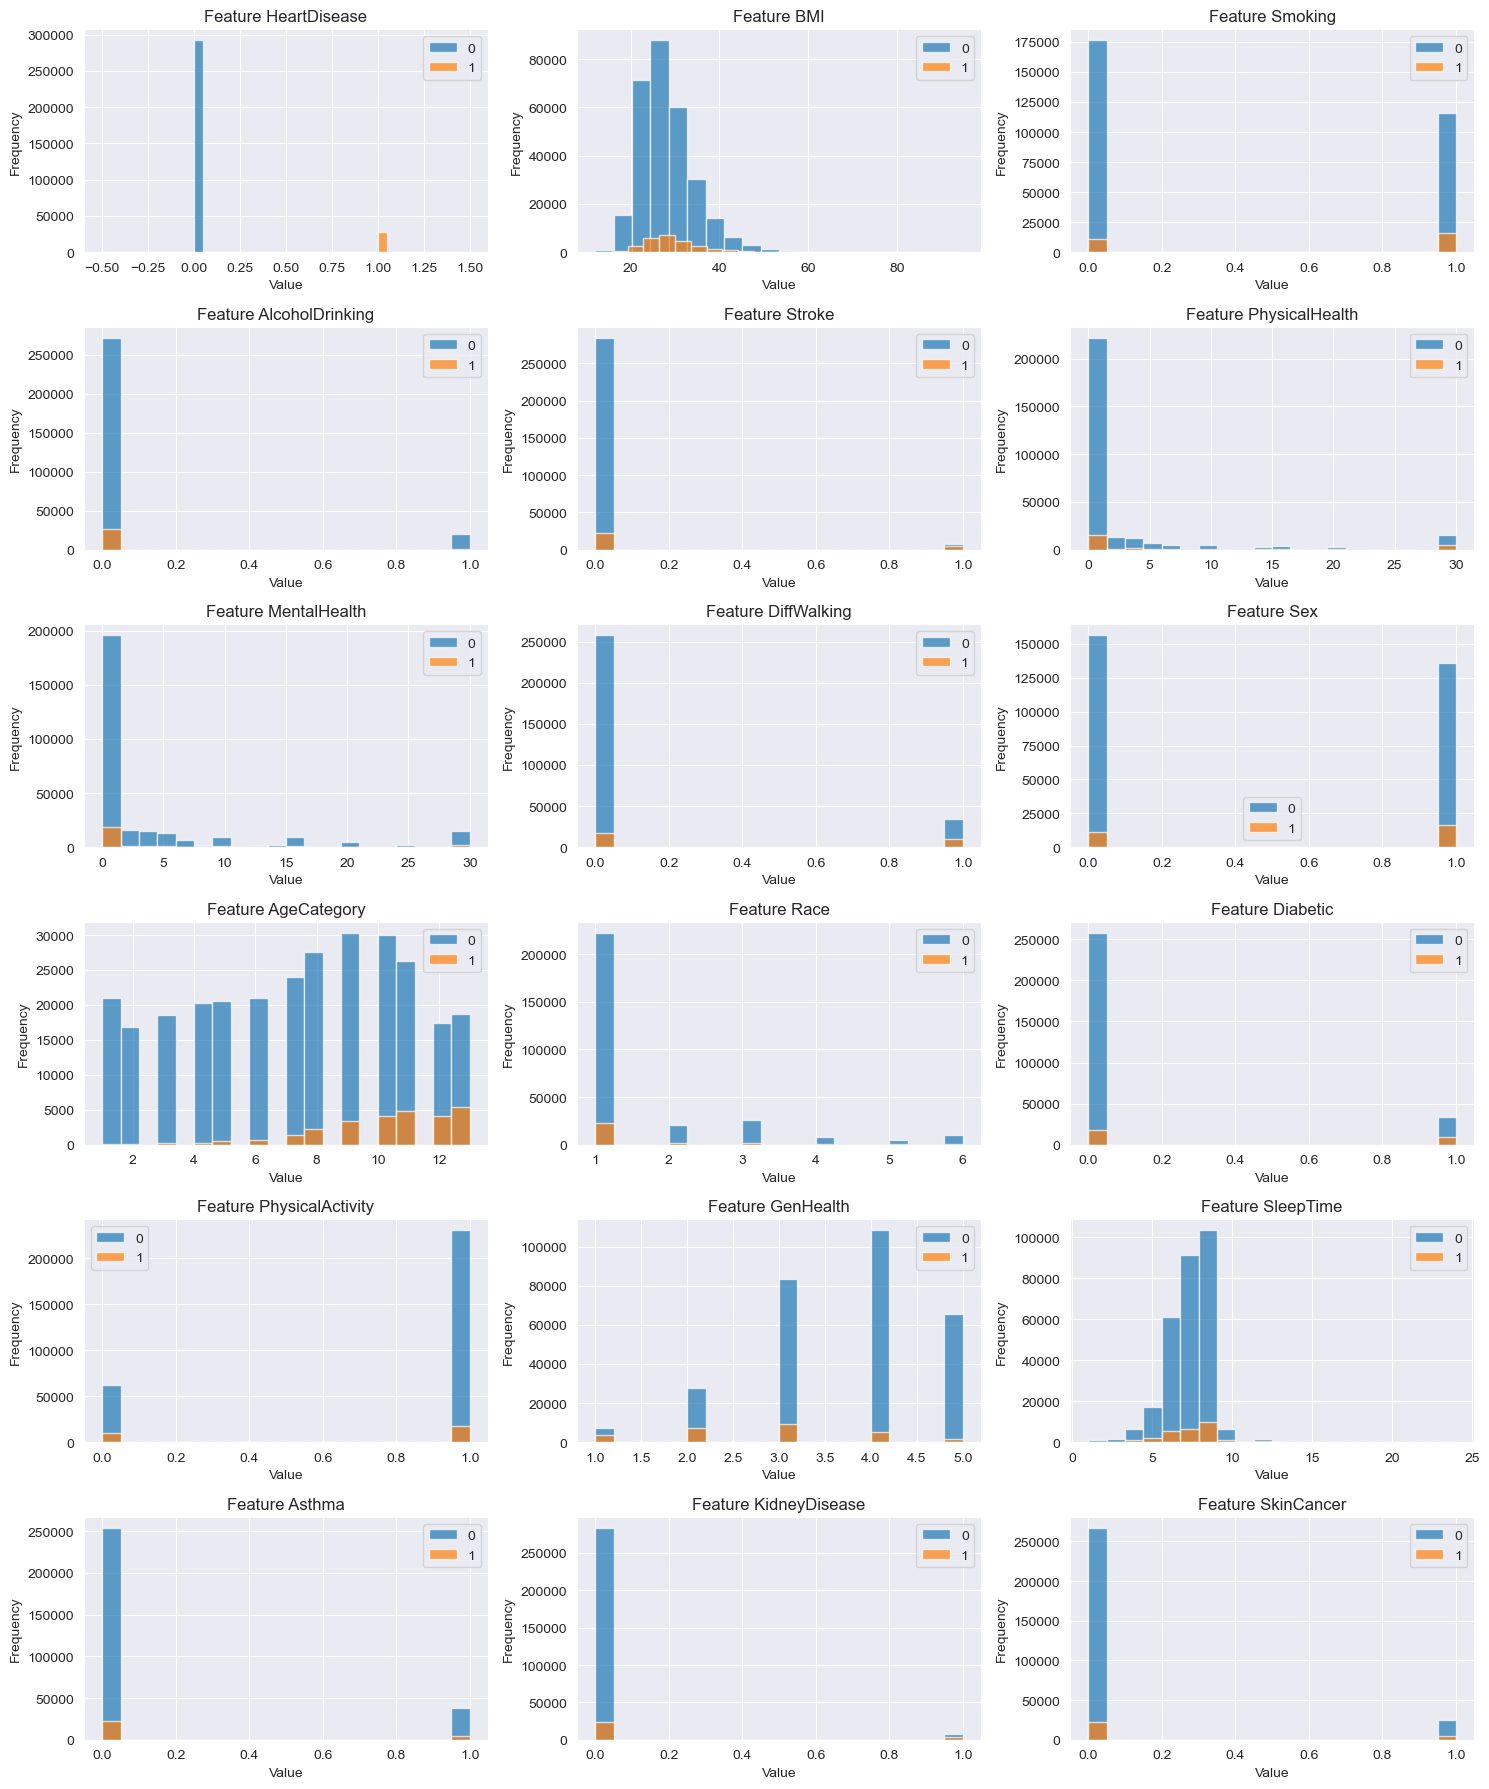

In [107]:
data_visualization = DataVisualization(data_loader, ['correlation', 'box', 'barh'])
data_visualization.plot_all_features()

# Outliers
During the examination of the plots, we detected outliers within the data, prompting a closer inspection of these influential data points.

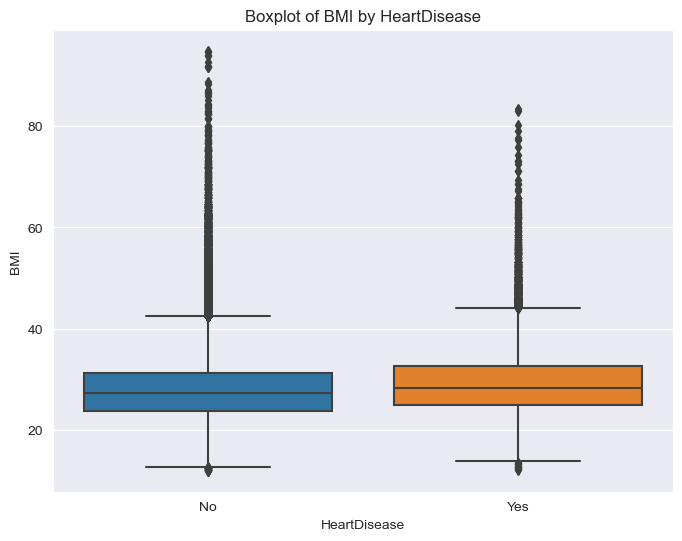

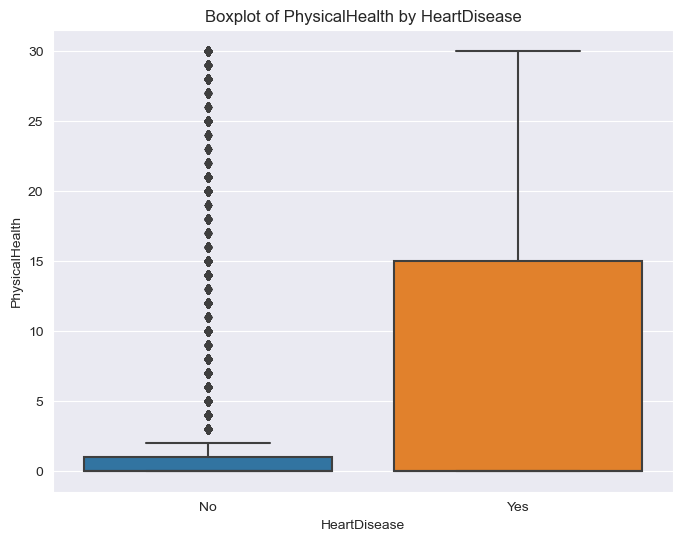

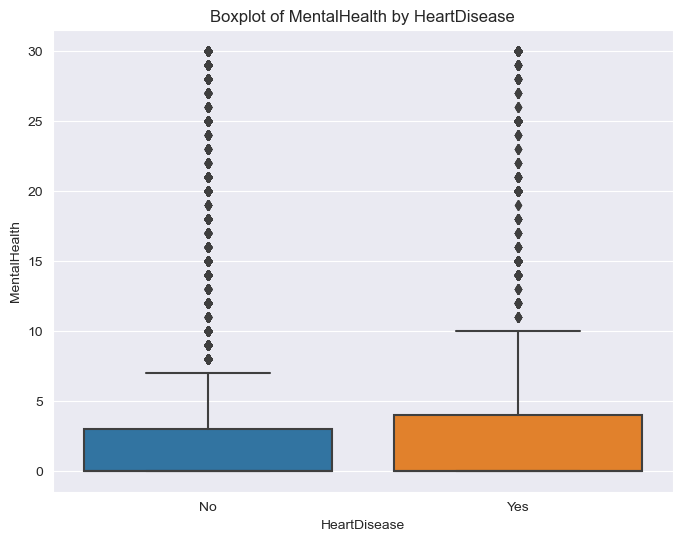

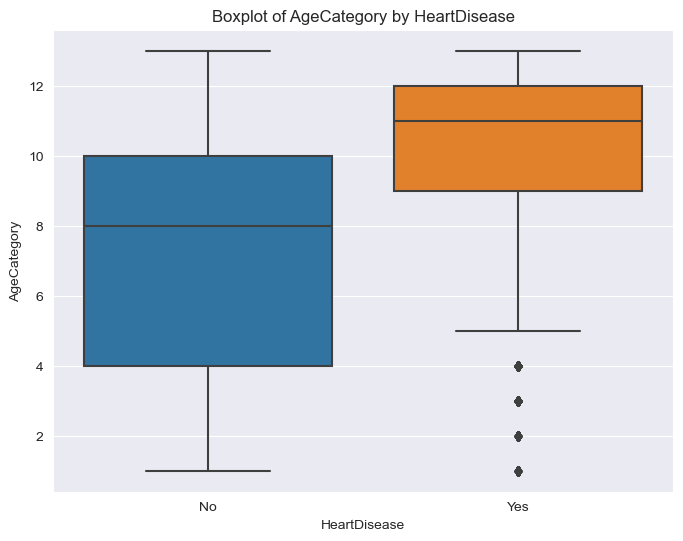

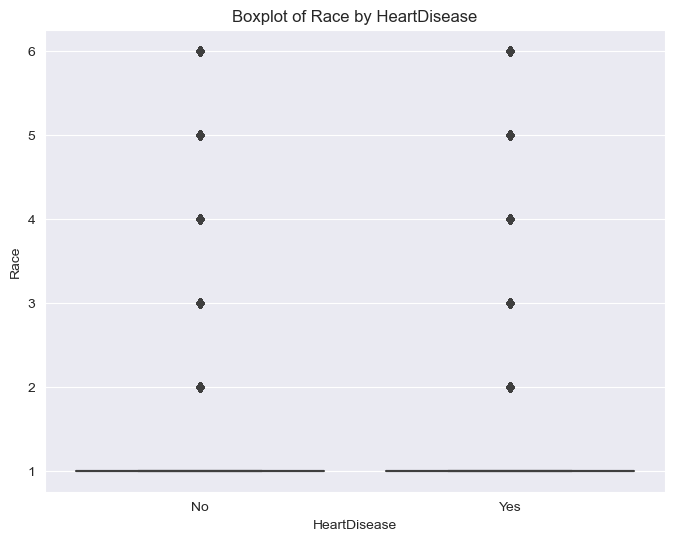

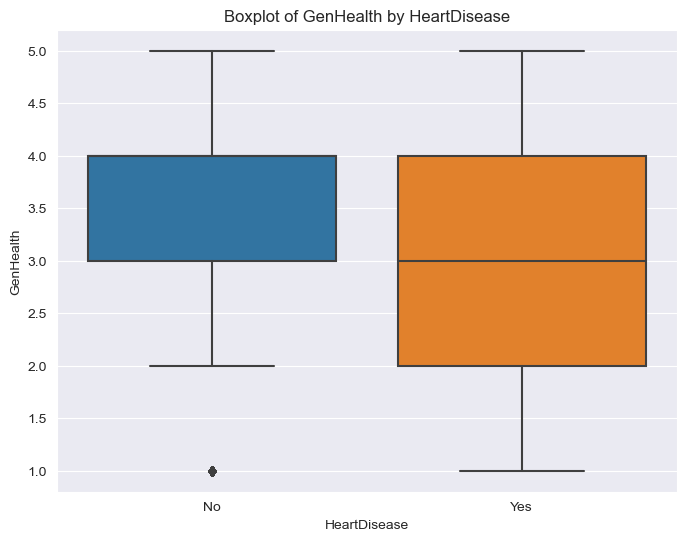

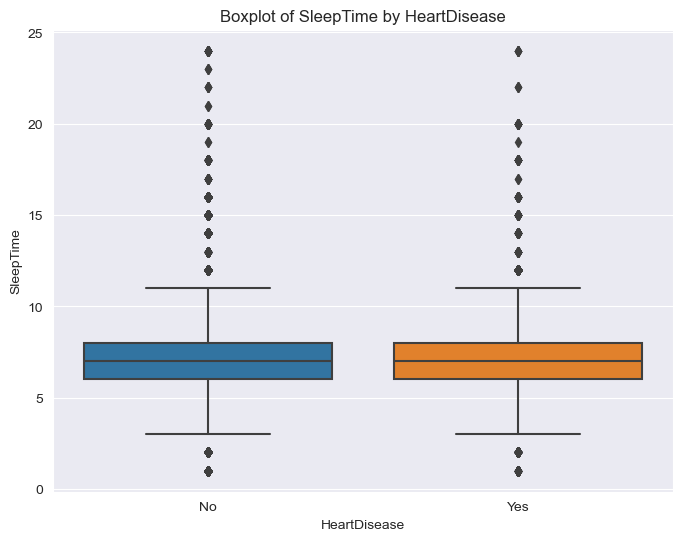

In [108]:
data_visualization.plots(['box'])

# Clean the data

Ensuring the reliability of datasets is paramount in data analysis. The DataCleaning class outlined below tackles this by addressing duplicate entries and outliers. Initial steps involved purging duplicates, followed by meticulous outlier identification and correction.

When detecting outliers, we focus solely on features with more than two unique values. This approach is pragmatic, as features with fewer unique values are not meaningful candidates for outlier analysis and are consequently removed from consideration.


In [109]:
data_cleaner = DataCleaning(data_loader)
data_cleaner.handle_missing_values()
data_cleaner.remove_duplicates()
data_cleaner.detect_and_remove_outliers()


Original Dataset before cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  int64  
 9   AgeCategory       319795 non-null  int64  
 10  Race              319795 non-null  int64  
 11  Diabetic          319795 non-null  int64  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  int64  
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null

# Histograms after cleaning

Let's visualize the distribution of our features after cleaning dataset.


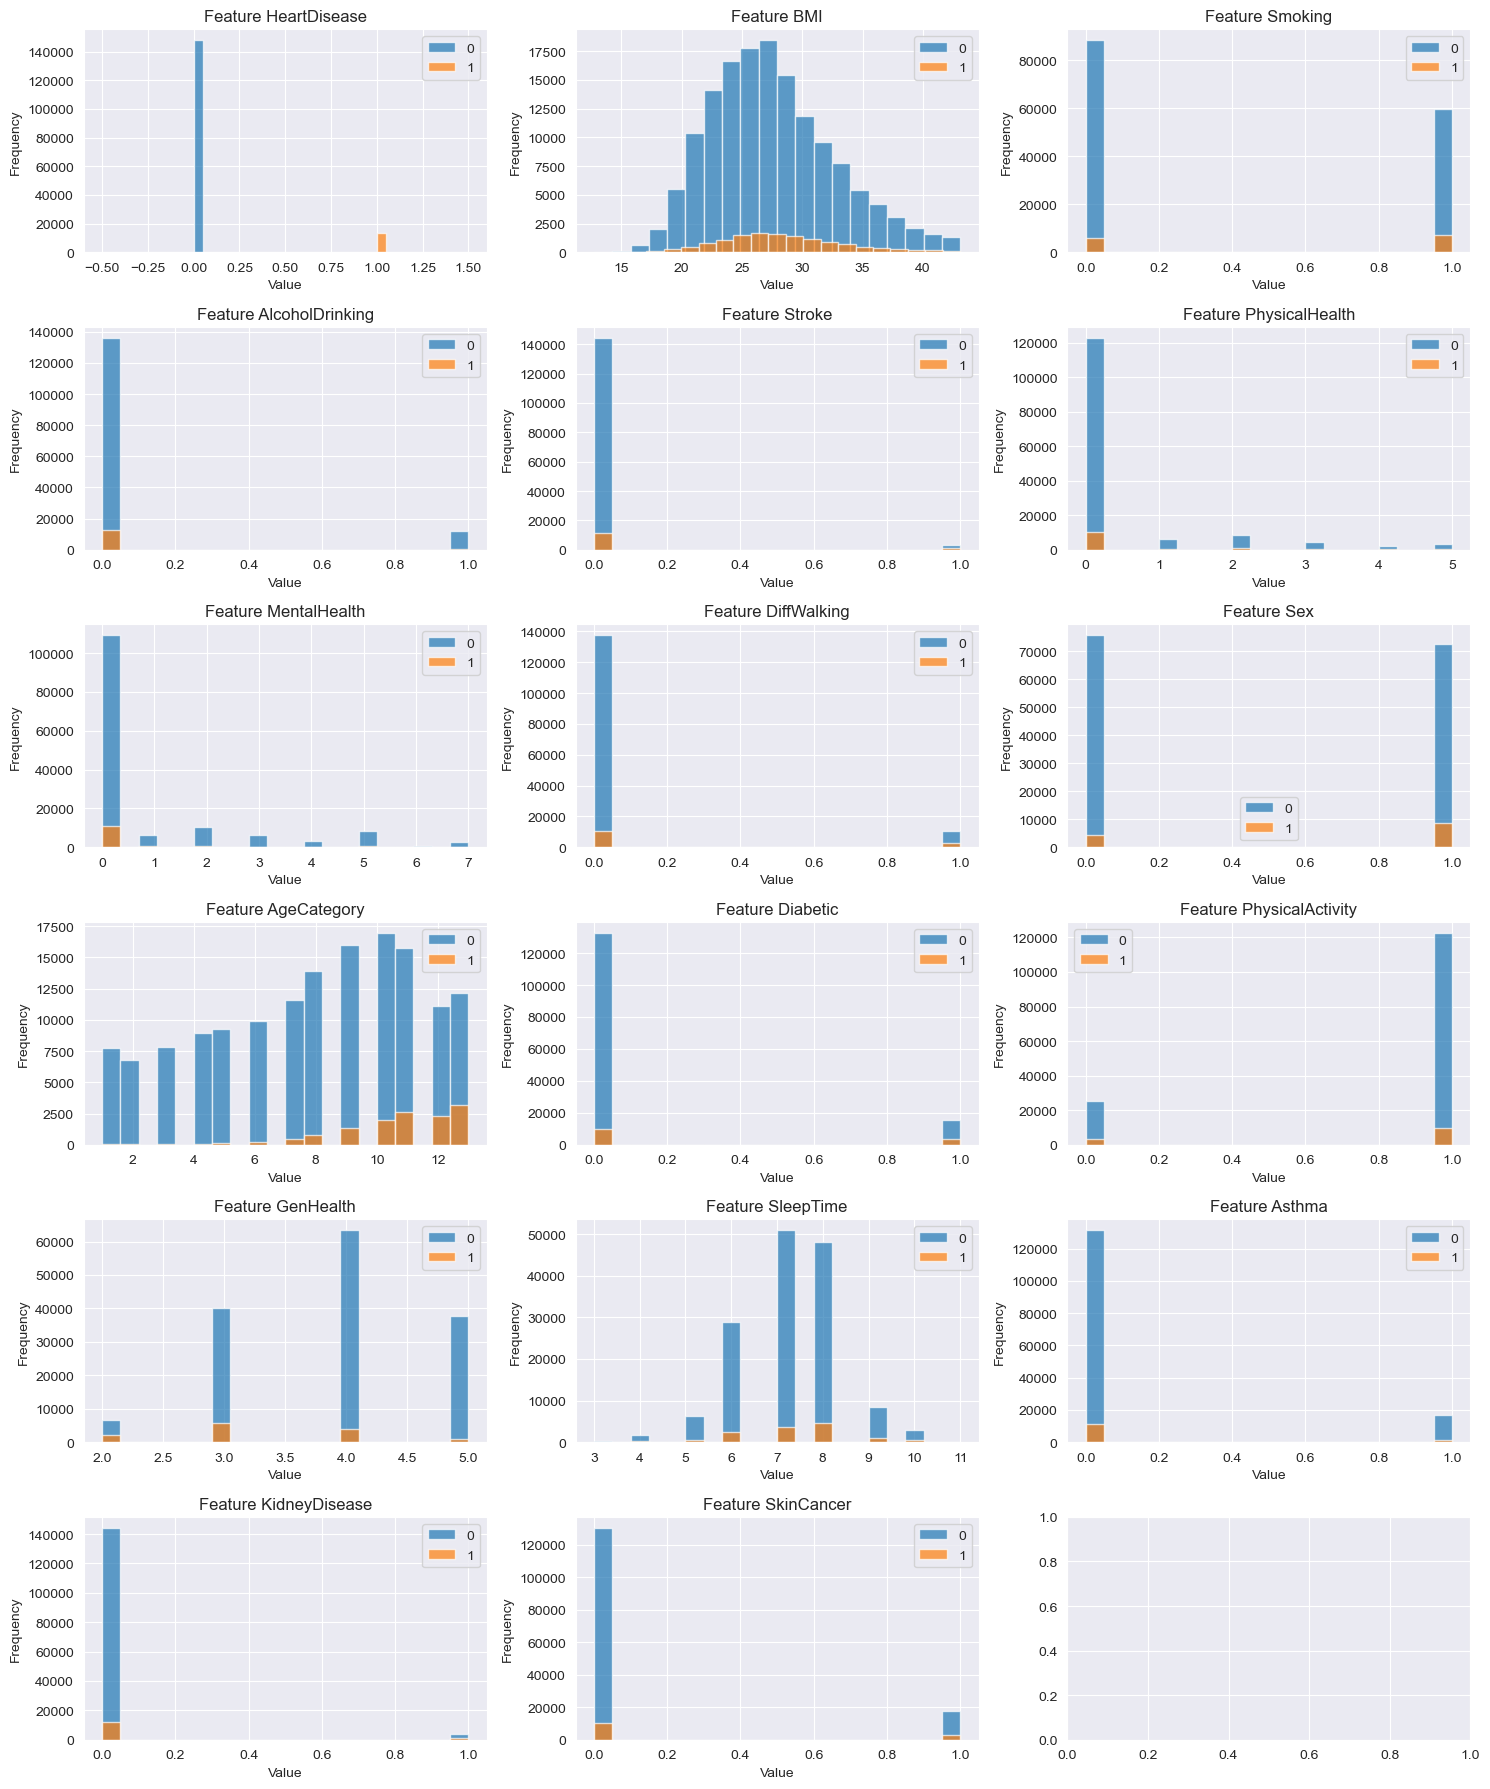

In [110]:
data_visualization.plot_all_features()

# Correlation and Permutation Importance
This heatmap visually represents the correlations between variables, with color gradients indicating the strength and direction of these relationships. In our specific analysis focused on HeartDisease, we assessed the correlations with various features. The correlation values, presented below, showcase the degree of association.
Following the heatmap analysis, we proceeded to perform a Permutation Importance analysis and visualized the results through a horizontal bar chart ('barh'). This approach allows us to delve deeper into the importance of each feature in predicting HeartDisease.

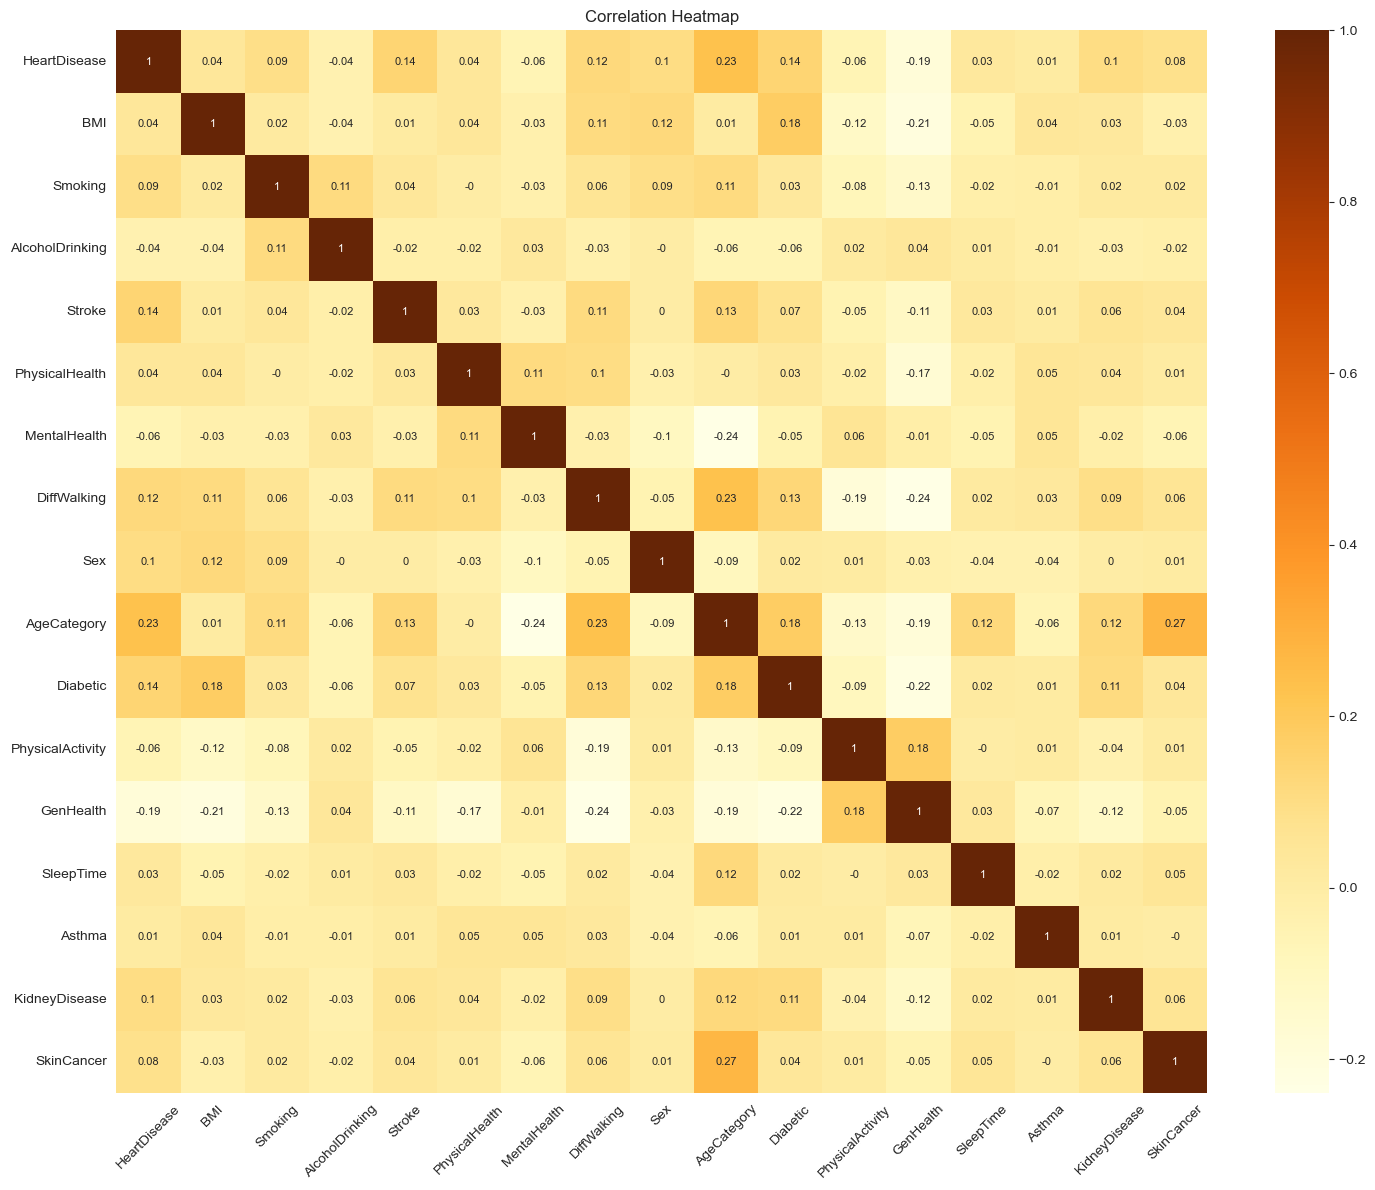


Correlation of the features with Heart Disease:

HeartDisease        1.00
AgeCategory         0.23
Diabetic            0.14
Stroke              0.14
DiffWalking         0.12
KidneyDisease       0.10
Sex                 0.10
Smoking             0.09
SkinCancer          0.08
BMI                 0.04
PhysicalHealth      0.04
SleepTime           0.03
Asthma              0.01
AlcoholDrinking    -0.04
MentalHealth       -0.06
PhysicalActivity   -0.06
GenHealth          -0.19
Name: HeartDisease, dtype: float64


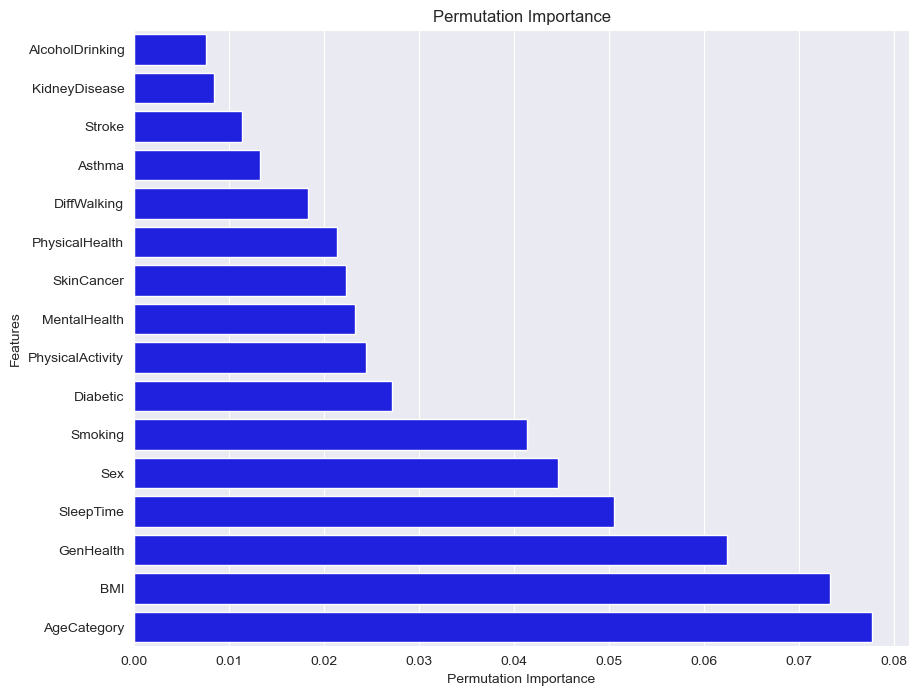

In [111]:
data_visualization.plots(['correlation', 'barh'])

# Dimensionality Reduction Selection

For our dataset, we opted for dimensionality reduction using UMAP and PCA. Through experimentation, these two methods consistently delivered the best results. UMAP excels in capturing intricate relationships, while PCA efficiently handles linear dimensionality reduction. Together, they provide a balanced approach to preserving essential data features in reduced dimensions.

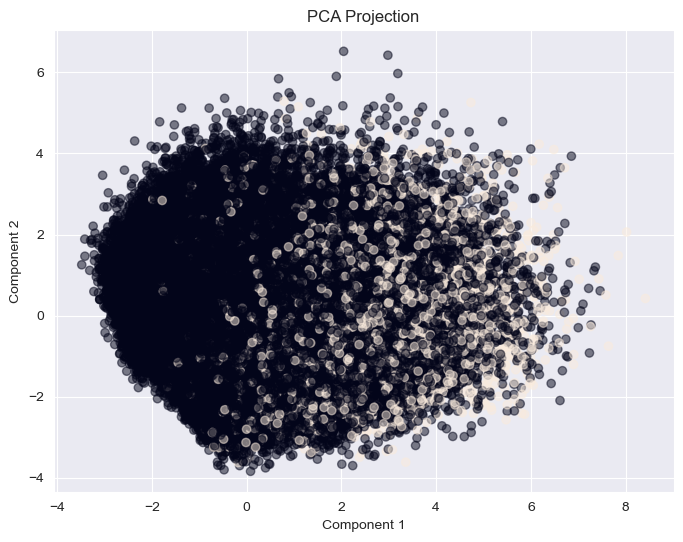

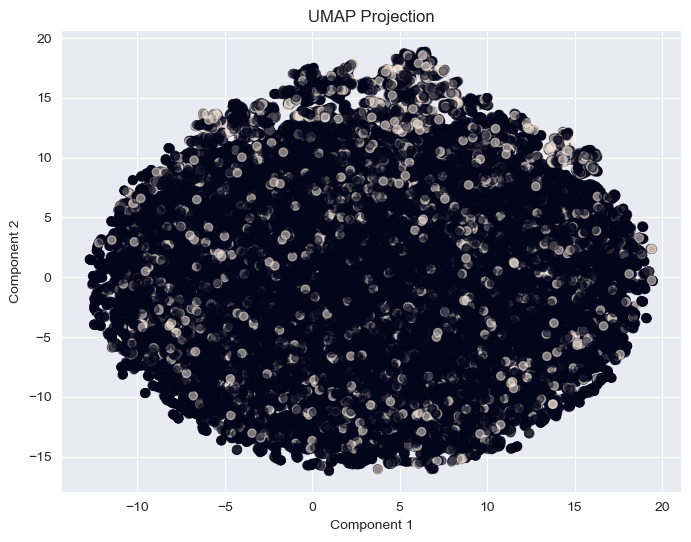

In [112]:
dr = DimensionalityReduction(data_loader)
dr.plot_projection(dr.compute_pca(), 'PCA Projection')
dr.plot_projection(dr.compute_umap(), 'UMAP Projection')

# Hypothesis Testing

## Normality Test

Before delving into the exploration of feature importance, we first sought to understand the distributional characteristics of our data. To achieve this, we initially employed Shapiro-Wilk tests, aiming to assess the normality of our feature distributions.

However, the results from the Shapiro-Wilk tests yielded p-values that were remarkably close to zero or even zero itself due to the size of our dataset. This indicates challenges in accepting the null hypothesis of normality for our dataset.


In [113]:
tester = HypothesisTester(data_loader)
tester.test_normality()


Normality Test:

BMI_with_HD:
Shapiro-Wilk test - Test statistic: 0.9839165806770325, p-value: 7.054543092594313e-36
Smoke_with_HD:
Shapiro-Wilk test - Test statistic: 0.6317048072814941, p-value: 0.0
Alcohol_with_HD:
Shapiro-Wilk test - Test statistic: 0.19969838857650757, p-value: 0.0
Stroke_with_HD:
Shapiro-Wilk test - Test statistic: 0.36499863862991333, p-value: 0.0
PH_with_HD:
Shapiro-Wilk test - Test statistic: 0.49373501539230347, p-value: 0.0
MH_with_HD:
Shapiro-Wilk test - Test statistic: 0.4167599678039551, p-value: 0.0
DW_with_HD:
Shapiro-Wilk test - Test statistic: 0.4841189384460449, p-value: 0.0
Sex_with_HD:
Shapiro-Wilk test - Test statistic: 0.5943844318389893, p-value: 0.0
AC_with_HD:
Shapiro-Wilk test - Test statistic: 0.8758070468902588, p-value: 0.0
Diabetic_with_HD:
Shapiro-Wilk test - Test statistic: 0.5502186417579651, p-value: 0.0
PA_with_HD:
Shapiro-Wilk test - Test statistic: 0.5430656671524048, p-value: 0.0
GH_with_HD:
Shapiro-Wilk test - Test statistic: 0.

## QQ plots
However, upon observing that the Shapiro-Wilk tests did not provide as much clarity as desired, we turned to a visual approach using QQ plots. By visually inspecting which plot, with points following the diagonal line, we identified that both `BMI_with_HD` and `BMI_without_HD` displayed distributional characteristics aligning with normality.

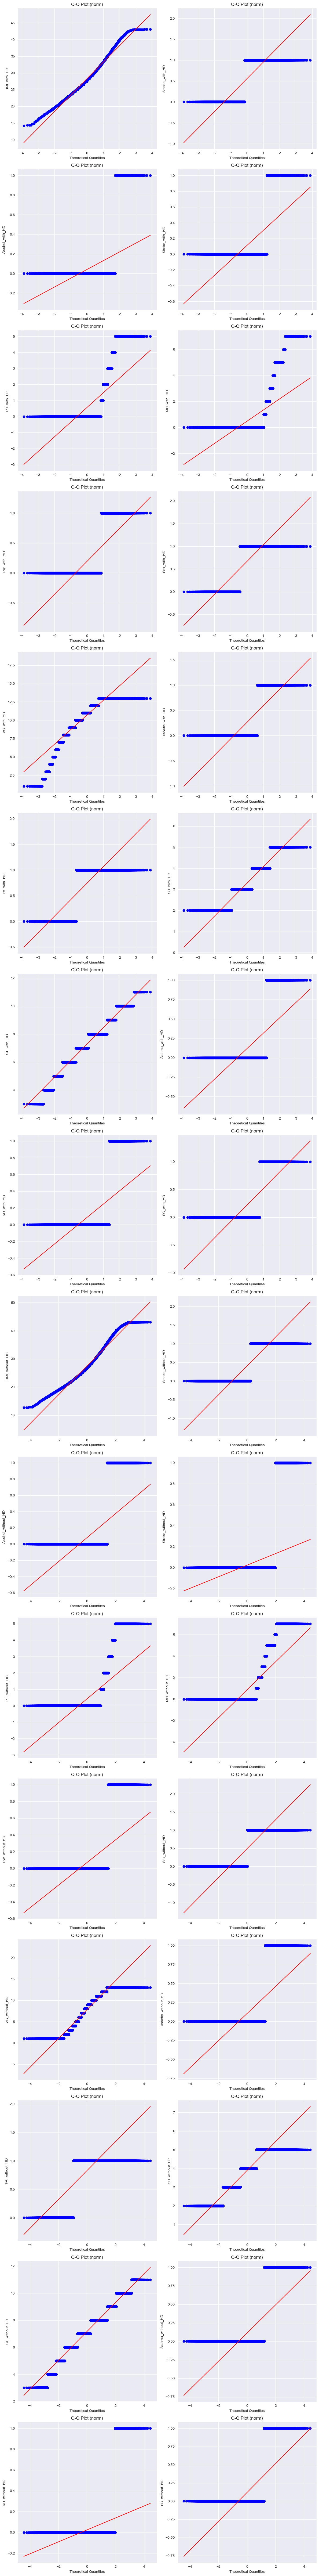

In [114]:
tester.qq_plots()

## Hypothesis Testing techniques
To explore the distributional characteristics of our data, especially considering the unpaired nature of our dataset (where there is no before-and-after relationship for the same individual), we employed hypothesis testing techniques.

For normally distributed variables (as determined through visual inspection using QQ plots), we utilized the unpaired t-test. This statistical test helps us compare means between two independent groups. In our case, it was applied to features such as `BMI_with_HD`.

For non-normally distributed variables, the Wilcoxon rank-sum test was chosen. This non-parametric test is suitable for comparing medians between two independent groups. It was employed for features that did not exhibit normal distribution characteristics, like `Diabetic_without_HD`.


In [115]:
tester.distribute_normality_data()
tester.perform_tests()


Unpaired T-test tests for the normal distributed variables:

Unpaired T-test test between the array of BMI with HeartDisease and the array without : 
t-statistic: 17.254401781981944
p-value: 1.1905616160893273e-66

Wilcoxon rank-sum tests for the not normal distributed variables:

Wilcoxon rank-sum test between the array of Smoking with HeartDisease and the array without : 
Test statistic: 1123898697.5
p-value: 2.6523990551684948e-260

Wilcoxon rank-sum test between the array of AlcoholDrinking with HeartDisease and the array without : 
Test statistic: 936963302.5
p-value: 3.9844484286754034e-54

Wilcoxon rank-sum test between the array of Stroke with HeartDisease and the array without : 
Test statistic: 1059749252.5
p-value: 0.0

Wilcoxon rank-sum test between the array of PhysicalHealth with HeartDisease and the array without : 
Test statistic: 1005754861.5
p-value: 4.693516597849764e-22

Wilcoxon rank-sum test between the array of MentalHealth with HeartDisease and the array withou

# Feature Creation
Informed by our exploration and hypothesis testing, we decided to create 10 new features that we believe hold significance for our investigation. These features were chosen based on their notable correlation with heart diseases, and we anticipate their utility in enhancing our predictive model. Below, you can find the names of these newly created features, along with the new histograms and a correlation heatmap for visual reference:

## New Features

- **BMIClass**: Categorizes BMI data into eight distinct groups, ranging from severe thinness to extreme obesity, providing a comprehensive representation of BMI values in the dataset.
- **SleepClass**: Divides sleep duration into three categories, enabling the assessment of its impact on heart disease risk.
- **BadHabitsScore**: Combines Smoking and AlcoholDrinking features to create a composite score reflecting unhealthy lifestyle habits, with higher scores indicating more detrimental habits.
- **Diseases**: Aggregates information from various disease-related features to create a composite score representing the number of diseases present, aiding in assessing overall health status.
- **PoorHealthDaysMonth**: Calculates the average number of days of poor mental and physical health experienced per month, providing an overall assessment of an individual's health status.
- **DangerousStroke**: Identifies cases of stroke among individuals aged 65 or above, facilitating the evaluation of stroke risk in the elderly population.
- **AgeBMI_Interaction**: Represents the interaction between AgeCategory and BMI, offering insights into how age influences the relationship between BMI and health outcomes.
- **BMISleep_Interaction**: Captures the interaction between BMI and sleep duration, shedding light on the combined effects of these factors on health.
- **AgeHealth_Interaction**: Reflects the interaction between AgeCategory and general health, providing insights into how age influences the relationship between health status and age.
- **AgeSleep_Interaction**: Represents the interaction between AgeCategory and sleep duration, highlighting how age influences the relationship between sleep patterns and health.


In [116]:
feature_creator = FeatureCreation(data_loader)
feature_creator.create_modified_features()
feature_creator.create_joined_features()
feature_creator.create_interaction_features()

Created BMIClass feature

Created SleepClass feature

Created BadHabitsScore feature

Created Diseases feature

Created PoorHealthDaysMonth feature

Created DangerousStroke feature

Created AgeBMI_Interaction feature

Created BMISleep_Interaction feature

Created AgeHealth_Interaction feature

Created AgeSleep_Interaction feature


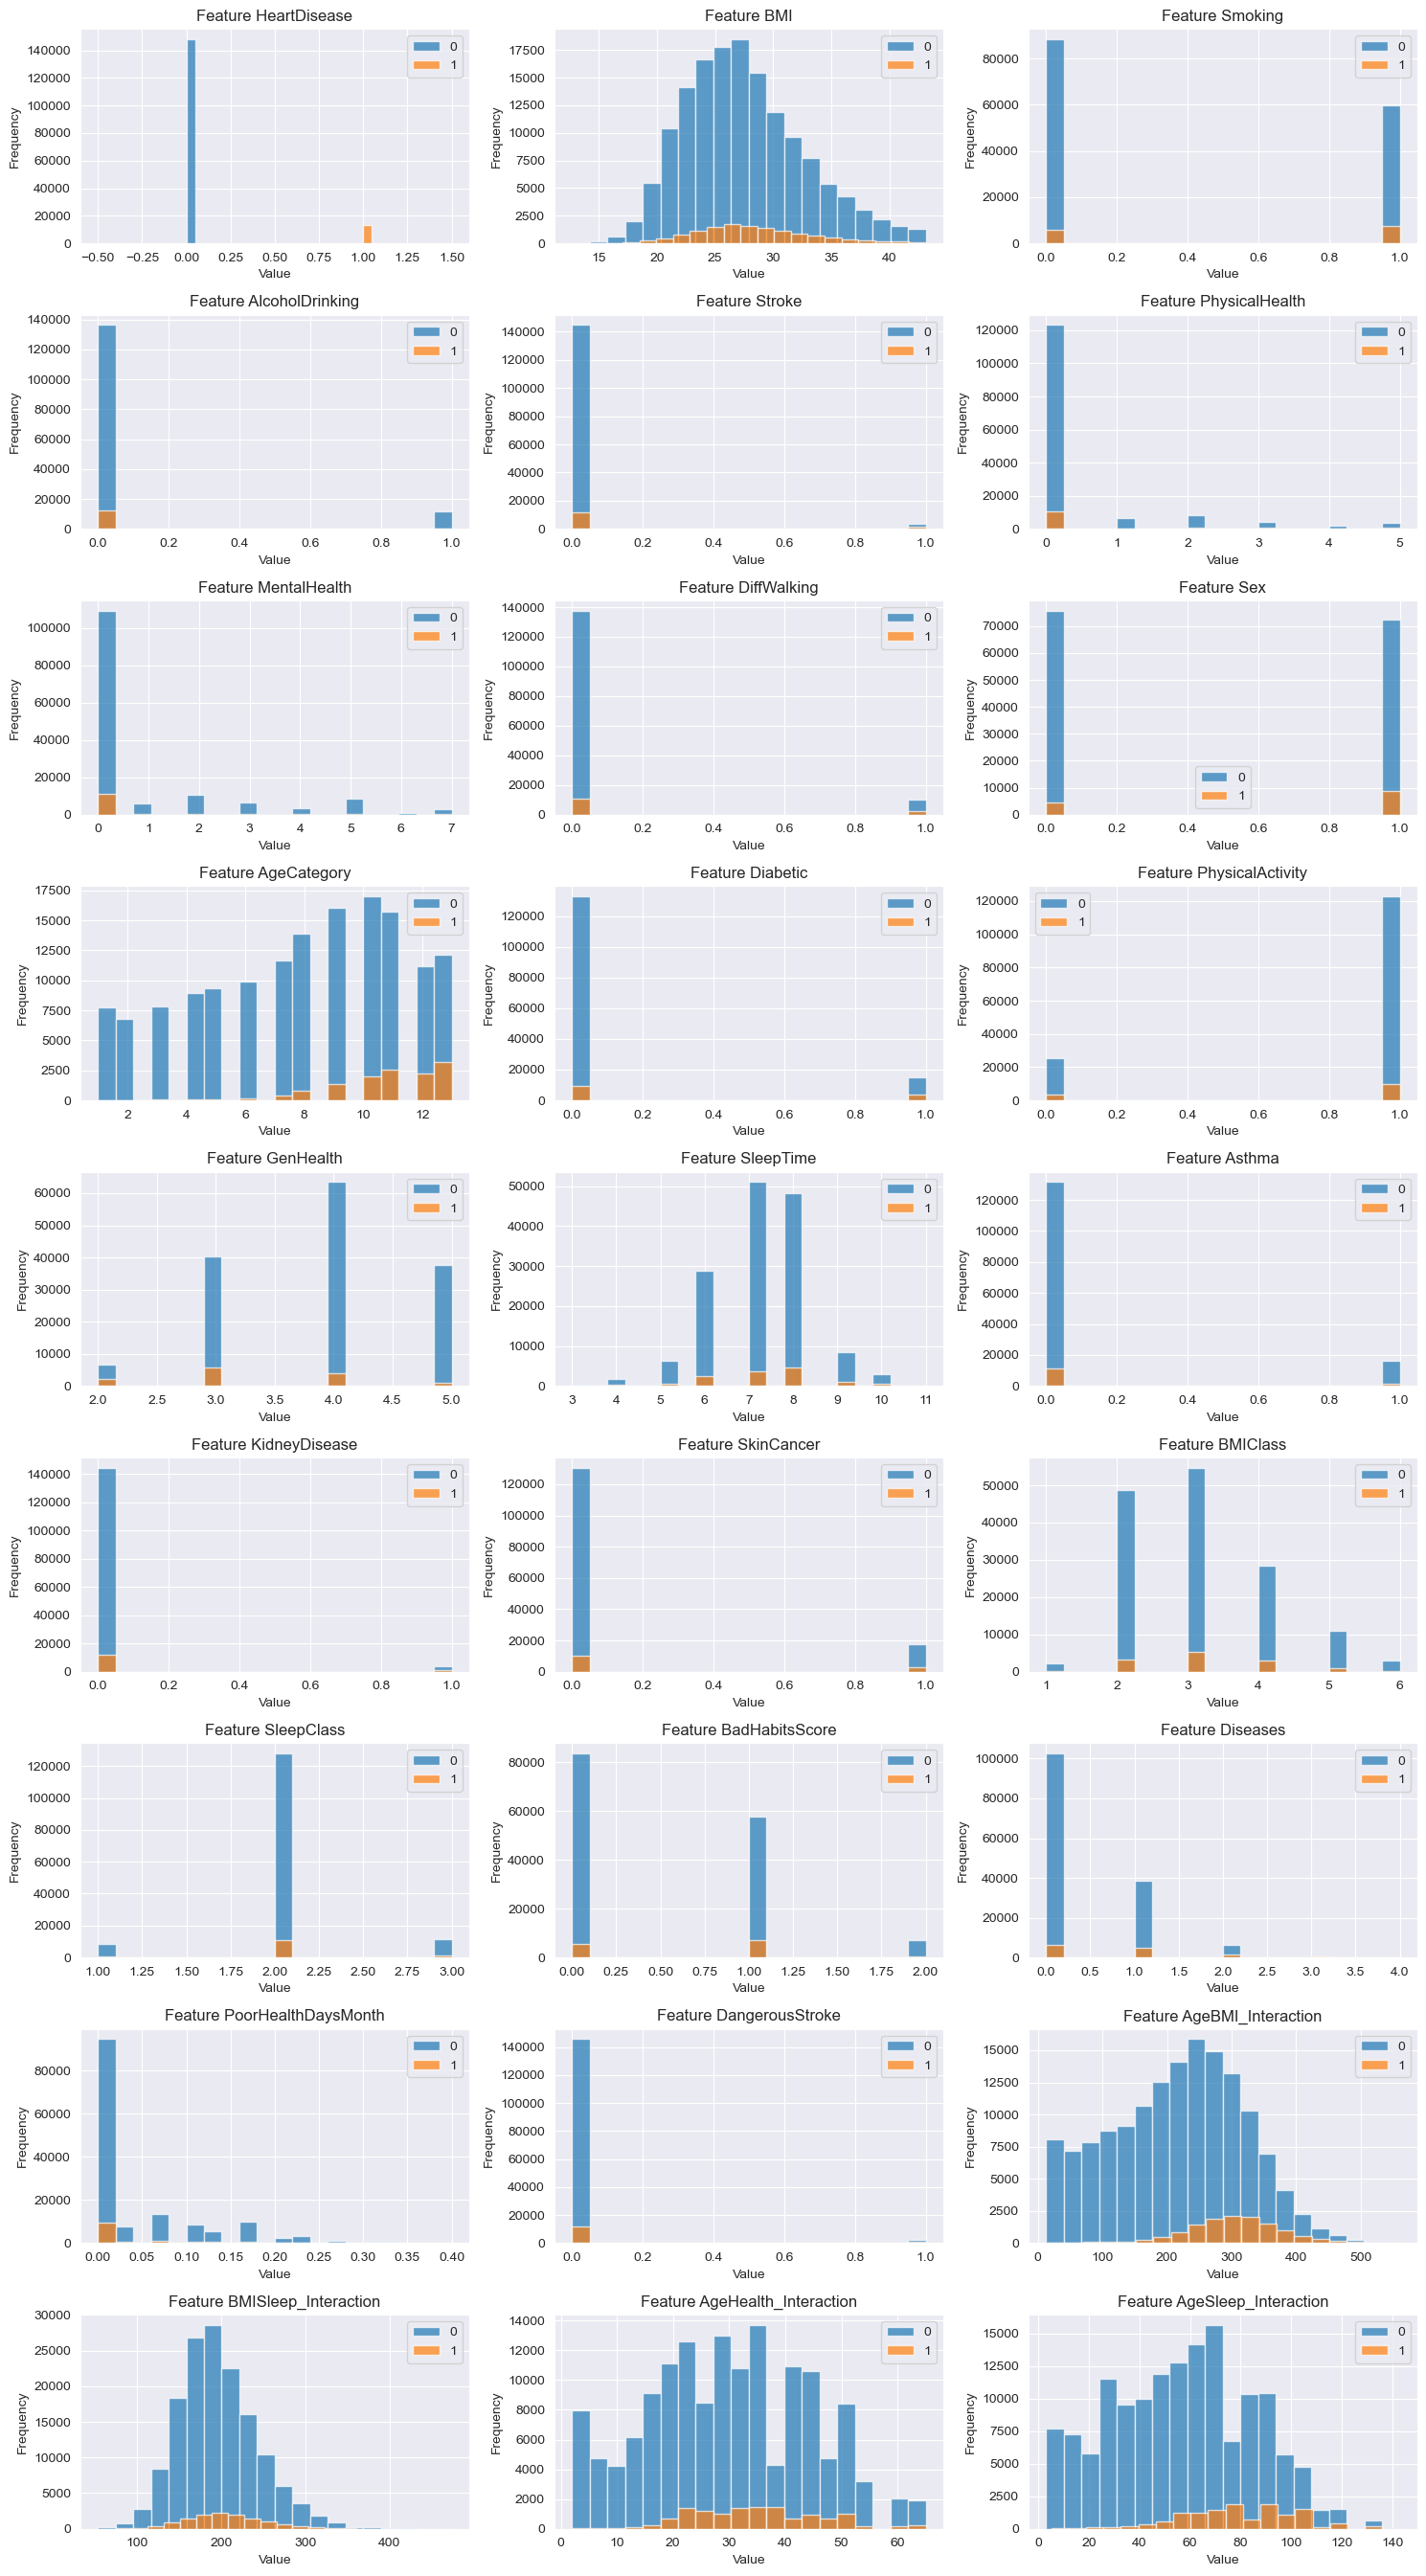

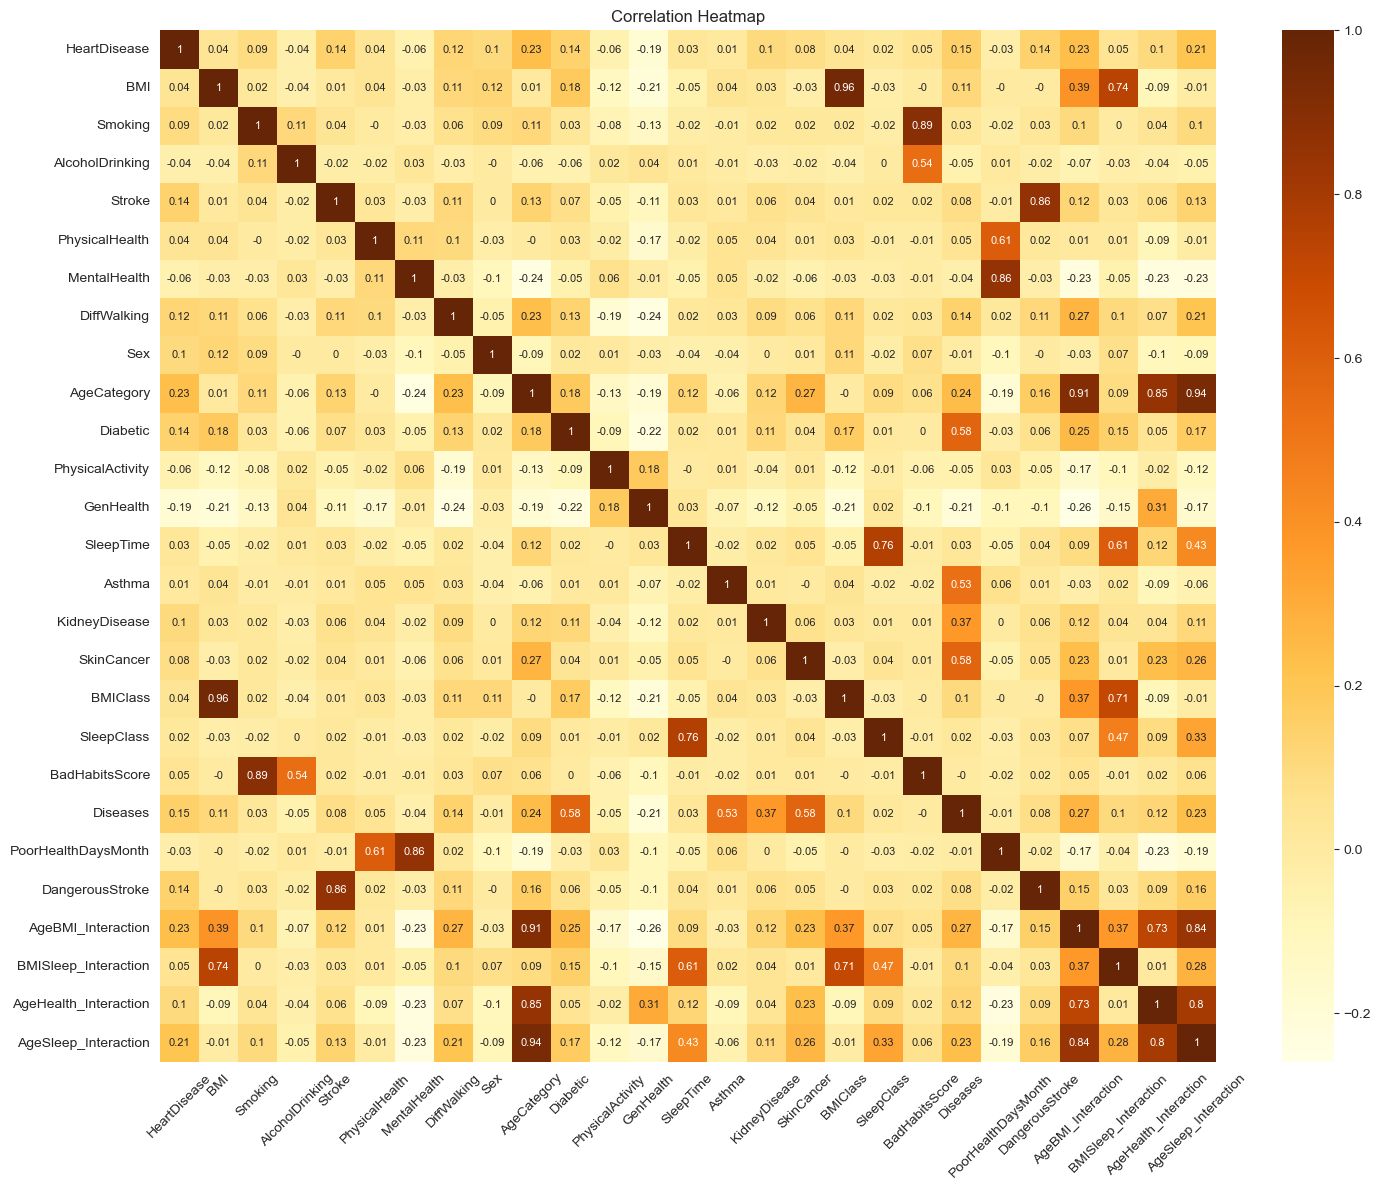


Correlation of the features with Heart Disease:

HeartDisease             1.00
AgeCategory              0.23
AgeBMI_Interaction       0.23
AgeSleep_Interaction     0.21
Diseases                 0.15
Stroke                   0.14
Diabetic                 0.14
DangerousStroke          0.14
DiffWalking              0.12
AgeHealth_Interaction    0.10
KidneyDisease            0.10
Sex                      0.10
Smoking                  0.09
SkinCancer               0.08
BadHabitsScore           0.05
BMISleep_Interaction     0.05
BMI                      0.04
PhysicalHealth           0.04
BMIClass                 0.04
SleepTime                0.03
SleepClass               0.02
Asthma                   0.01
PoorHealthDaysMonth     -0.03
AlcoholDrinking         -0.04
PhysicalActivity        -0.06
MentalHealth            -0.06
GenHealth               -0.19
Name: HeartDisease, dtype: float64


In [117]:
data_visualization.plot_all_features()
data_visualization.plots(['correlation'])